### TASK:

- You are employed as a data scientist at the Open University (commonly known as OU). The OU is one of the largest UK universities (by student numbers) and is the pioneer of distance learning, it is known for its distance learning focus, accessibility to students with underprivileged backgrounds (both in the sense of societal and academic), wide range of degrees, and innovative technologies. The university has recently purchased a brand new virtual learning environment (VLE). You are tasked with providing scientific evidence for the following questions:

    - Is the VLE improving students' grades?
    - Can we predict students' grades?

    <br>
- Depending on the results of your analyses, we also want some actionable recommendations, such as actively promoting the VLE to students to improve grades or changing assessment types.

In [1802]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import RFE

### Just to show versions
import scipy
import matplotlib
import sklearn

In [1803]:
print( f'Version of Pandas: {pd.__version__}' )
print( f'Version of Numpy: {np.__version__}' )
print( f'Version of Seaborn: {sns.__version__}' )
print( f'Version of Matplotlib: {matplotlib.__version__}' )
print( f'Version of Scipy: {scipy.__version__}' )
print( f'Version of Scikit-Learn: {sklearn.__version__}' )

Version of Pandas: 2.2.3
Version of Numpy: 2.0.2
Version of Seaborn: 0.13.2
Version of Matplotlib: 3.9.2
Version of Scipy: 1.14.1
Version of Scikit-Learn: 1.5.2


In [1804]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Reading the data as demanded

In [1805]:
def read_data( fname: str ) -> pd.DataFrame:
   '''
   fname: str -> The data path where all csv files saved in.
   '''
   datasets = {}
   try:
      df1 = pd.read_csv( f'{fname}/assessments.csv' )
      df2 = pd.read_csv( f'{fname}/courses.csv' )
      df3 = pd.read_csv( f'{fname}/studentAssessment.csv' )
      df4 = pd.read_csv( f'{fname}/studentInfo.csv' )
      df5 = pd.read_csv( f'{fname}/studentRegistration.csv' )
      df6 = pd.read_csv( f'{fname}/studentVle.csv' )
      df7 = pd.read_csv( f'{fname}/vle.csv' )
      
      datasets['assessments'] = df1
      datasets['courses'] = df2
      datasets['studentAssessment'] = df3
      datasets['studentInfo'] = df4
      datasets['studentRegistration'] = df5
      datasets['studentVle'] = df6
      datasets['vle'] = df7

      print( 'Data successfully read!' )
      return datasets
   except FileNotFoundError:
      print( 'File Not Found! Please check your data path again.' )
      return None
   except Exception as E:
      print( f'An error occured when reading the data: { E }' )
      return None

In [1806]:
datasets = read_data( 'data' )

Data successfully read!


In [1807]:
datasets.keys()

dict_keys(['assessments', 'courses', 'studentAssessment', 'studentInfo', 'studentRegistration', 'studentVle', 'vle'])

In [1808]:
def describe_data( data: pd.DataFrame, isCategorical: bool = False ) -> pd.DataFrame:
    '''
    Returns a summary of the data.
    If isCategorical is True, returns a summary of the categorical data
        o/w returns a summary of the numerical data
    
    Parameters:
    data: pd.DataFrame -> Dataframe object
    isCategorical: bool ->  Boolean object to define to investigate whether numerical or categorical columns 

    '''
    
    if not isCategorical:
        return data.describe( include=['int', 'float'] ).T
    
    return data.describe( exclude=['int', 'float'] ).T

In [1809]:
def find_common_columns( df1: pd.DataFrame, df2: pd.DataFrame ) -> list:
    return list( set( df1.columns.tolist() ) & set( df2.columns.tolist() ) )

## Read Assessments Data

In [1810]:
assessments_df = datasets['assessments']
assessments_df.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19,10.0
1,AAA,2013J,1753,TMA,54,20.0
2,AAA,2013J,1754,TMA,117,20.0
3,AAA,2013J,1755,TMA,166,20.0
4,AAA,2013J,1756,TMA,215,30.0


* code_module &rarr; identification code of the module, to which the assessment belongs.
<br>
<br>
* code_presentation &rarr; identification code of the presentation, to which the assessment belongs.
<br>
<br>
* id_assessment &rarr; identification number of the assessment.
<br>
<br>
* assessment_type &rarr; type of assessment. Three types of assessments exist: Tutor Marked Assessment (TMA), Computer Marked Assessment (CMA) and Final Exam (Exam).
<br>
<br>
* date &rarr; information about the final submission date of the assessment calculated as the number of days since the start of the module-presentation. The starting date of the presentation has number 0 (zero).
<br>
<br>
* weight &rarr; weight of the assessment in %. Typically, Exams are treated separately and have the weight 100%; the sum of all other assessments is 100%.

#### Find the assessments that has not submitted yet and drop them from data frame as I think they might be some outliers

In [1811]:
non_submitted_assessments_index = assessments_df[(assessments_df.date == '?') & ((assessments_df.assessment_type == 'CMA') | (assessments_df.assessment_type == 'TMA'))].index
assessments_df.drop(index=non_submitted_assessments_index, inplace=True)

print( f'Number of non-submitted assessments: { len(non_submitted_assessments_index) }' )
non_submitted_assessments_index

Number of non-submitted assessments: 0


Index([], dtype='int64')

In [1812]:
assessments_df.groupby(['code_module', 'code_presentation', 'assessment_type'])\
.agg(weight = ('weight', 'sum'))

weight
code_module code_presentation assessment_type        
AAA         2013J             Exam              100.0
                              TMA               100.0
            2014J             Exam              100.0
                              TMA               100.0
BBB         2013B             CMA                 5.0
                              Exam              100.0
                              TMA                95.0
            2013J             CMA                 5.0
                              Exam              100.0
                              TMA                95.0
            2014B             CMA                 5.0
                              Exam              100.0
                              TMA                95.0
            2014J             Exam              100.0
                              TMA               100.0
CCC         2014B             CMA                25.0
                              Exam              200.0
                              TMA                75.0
            2014J             CMA                25.0
                              Exam              200.0
                              TMA                75.0
DDD         2013B             CMA                25.0
                              Exam              100.0
                              TMA                75.0
            2013J             Exam              100.0
                              TMA               100.0
            2014B             Exam              100.0
                              TMA               100.0
            2014J             Exam              100.0
                              TMA               100.0
EEE         2013J             Exam              100.0
                              TMA               100.0
            2014B             Exam              100.0
                              TMA               100.0
            2014J             Exam              100.0
                              TMA               100.0
FFF         2013B             CMA                 0.0
                              Exam              100.0
                              TMA               100.0
            2013J             CMA                 0.0
                              Exam              100.0
                              TMA               100.0
            2014B             CMA                 0.0
                              Exam              100.0
                              TMA               100.0
            2014J             CMA                 0.0
                              Exam              100.0
                              TMA               100.0
GGG         2013J             CMA                 0.0
                              Exam              100.0
                              TMA                 0.0
            2014B             CMA                 0.0
                              Exam              100.0
                              TMA                 0.0
            2014J             CMA                 0.0
                              Exam              100.0
                              TMA                 0.0

### Analysing data, including description, finding duplicated rows if any, and visualisations

In [1813]:
assessments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               206 non-null    object 
 5   weight             206 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 9.8+ KB


In [1814]:
describe_data( data = assessments_df )

,count,mean,std,min,25%,50%,75%,max
id_assessment,206.0,26473.975728,10098.625521,1752.0,15023.25,25364.5,34891.75,40088.0
weight,206.0,20.873786,30.384224,0.0,0.00,12.5,24.25,100.0


In [1815]:
describe_data( data = assessments_df, isCategorical = True )

,count,unique,top,freq
code_module,206,7,FFF,52
code_presentation,206,4,2014J,57
assessment_type,206,3,TMA,106
date,206,75,222,15


In [1816]:
duplicated_rows = assessments_df[ assessments_df.duplicated() ]
duplicated_rows

,code_module,code_presentation,id_assessment,assessment_type,date,weight


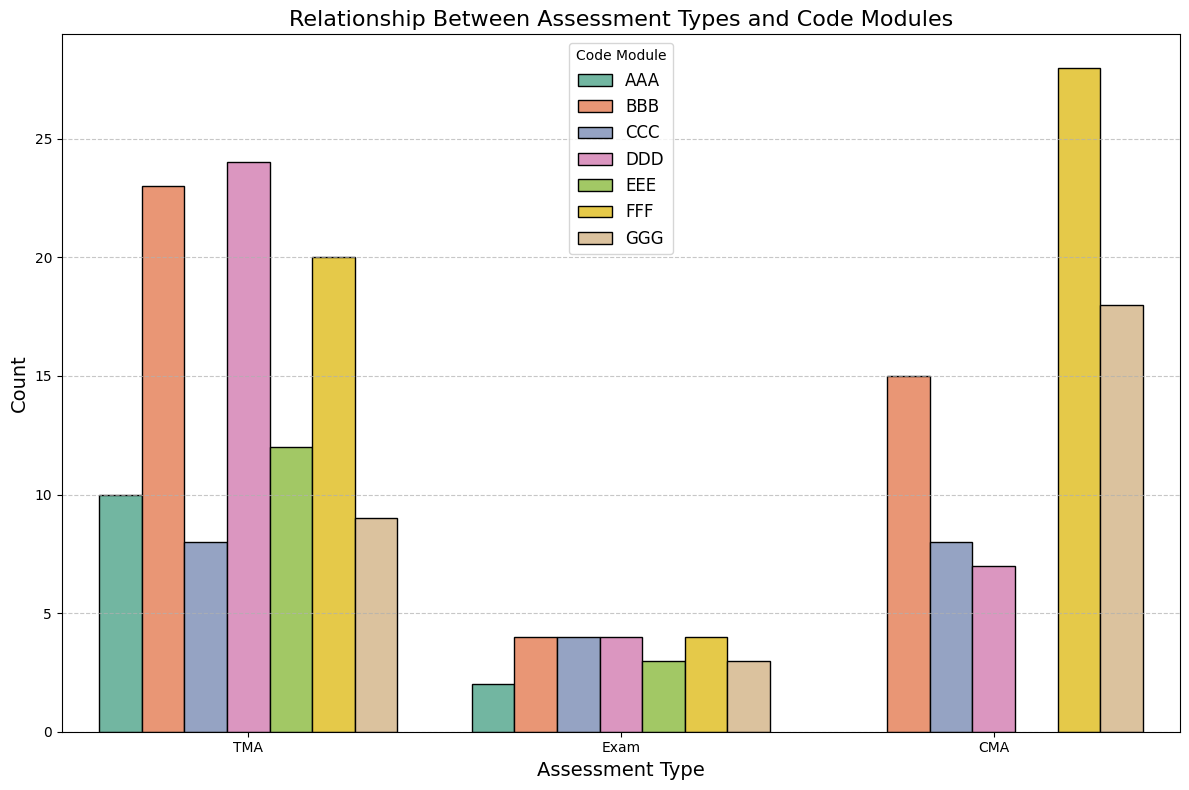

In [1817]:
plt.figure(figsize=(12, 8))
sns.countplot(data=assessments_df, x='assessment_type', hue='code_module', palette='Set2', edgecolor='black')
plt.title('Relationship Between Assessment Types and Code Modules', fontsize=16)
plt.xlabel('Assessment Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Code Module', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Read Courses Data

In [1818]:
courses_df = datasets['courses']
courses_df.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


* code_module &rarr; code name of the module, which serves as the identifier.
<br>
<br>
* code_presentation &rarr; code name of the presentation. It consists of the year and "B" for the presentation starting in February and "J" for the presentation starting in October.
<br>
<br>
* length &rarr; length of the module-presentation in days.

### Analysing data, including description, finding duplicated rows if any, and visualisations

In [1819]:
describe_data( courses_df )

,count,mean,std,min,25%,50%,75%,max
module_presentation_length,22.0,255.545455,13.654677,234.0,241.0,261.5,268.0,269.0


In [1820]:
describe_data( courses_df, True )

,count,unique,top,freq
code_module,22,7,BBB,4
code_presentation,22,4,2014J,7


In [1821]:
courses_df[ courses_df.duplicated( subset=['code_module', 'code_presentation'] )]

,code_module,code_presentation,module_presentation_length


### Merging Courses and Assessments Data

In [1822]:
common_cols = find_common_columns( assessments_df, courses_df )
common_cols

['code_module', 'code_presentation']

In [1823]:
course_assess_df = pd.merge( assessments_df, courses_df, how='inner', on=common_cols )
course_assess_df.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length
0,AAA,2013J,1752,TMA,19,10.0,268
1,AAA,2013J,1753,TMA,54,20.0,268
2,AAA,2013J,1754,TMA,117,20.0,268
3,AAA,2013J,1755,TMA,166,20.0,268
4,AAA,2013J,1756,TMA,215,30.0,268


In [1824]:
course_assess_df.shape

(206, 7)

In [1825]:
course_assess_df.groupby(['code_module', 'code_presentation', 'assessment_type'])\
.agg(weight_by_type = ('weight', 'sum'))

weight_by_type
code_module code_presentation assessment_type                
AAA         2013J             Exam                      100.0
                              TMA                       100.0
            2014J             Exam                      100.0
                              TMA                       100.0
BBB         2013B             CMA                         5.0
                              Exam                      100.0
                              TMA                        95.0
            2013J             CMA                         5.0
                              Exam                      100.0
                              TMA                        95.0
            2014B             CMA                         5.0
                              Exam                      100.0
                              TMA                        95.0
            2014J             Exam                      100.0
                              TMA                       100.0
CCC         2014B             CMA                        25.0
                              Exam                      200.0
                              TMA                        75.0
            2014J             CMA                        25.0
                              Exam                      200.0
                              TMA                        75.0
DDD         2013B             CMA                        25.0
                              Exam                      100.0
                              TMA                        75.0
            2013J             Exam                      100.0
                              TMA                       100.0
            2014B             Exam                      100.0
                              TMA                       100.0
            2014J             Exam                      100.0
                              TMA                       100.0
EEE         2013J             Exam                      100.0
                              TMA                       100.0
            2014B             Exam                      100.0
                              TMA                       100.0
            2014J             Exam                      100.0
                              TMA                       100.0
FFF         2013B             CMA                         0.0
                              Exam                      100.0
                              TMA                       100.0
            2013J             CMA                         0.0
                              Exam                      100.0
                              TMA                       100.0
            2014B             CMA                         0.0
                              Exam                      100.0
                              TMA                       100.0
            2014J             CMA                         0.0
                              Exam                      100.0
                              TMA                       100.0
GGG         2013J             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0
            2014B             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0
            2014J             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0

In [1826]:
unsubmitted_exam = course_assess_df[(course_assess_df['assessment_type'] == 'Exam') & (course_assess_df['date'] == '?')]
unsubmitted_exam.index, display( unsubmitted_exam )

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length
5,AAA,2013J,1757,Exam,?,100.0,268
11,AAA,2014J,1763,Exam,?,100.0,269
23,BBB,2013B,14990,Exam,?,100.0,240
35,BBB,2013J,15002,Exam,?,100.0,268
47,BBB,2014B,15014,Exam,?,100.0,234
53,BBB,2014J,15025,Exam,?,100.0,262
62,CCC,2014B,24290,Exam,?,100.0,241
63,CCC,2014B,40087,Exam,?,100.0,241
72,CCC,2014J,24299,Exam,?,100.0,269
73,CCC,2014J,40088,Exam,?,100.0,269


(Index([5, 11, 23, 35, 47, 53, 62, 63, 72, 73, 108], dtype='int64'), None)

In [1827]:
course_assess_df.date = course_assess_df.apply( lambda row: row['module_presentation_length'] if row['date'] == '?' else row['date'], axis=1 )

course_assess_df.loc[unsubmitted_exam.index, :]

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length
5,AAA,2013J,1757,Exam,268,100.0,268
11,AAA,2014J,1763,Exam,269,100.0,269
23,BBB,2013B,14990,Exam,240,100.0,240
35,BBB,2013J,15002,Exam,268,100.0,268
47,BBB,2014B,15014,Exam,234,100.0,234
53,BBB,2014J,15025,Exam,262,100.0,262
62,CCC,2014B,24290,Exam,241,100.0,241
63,CCC,2014B,40087,Exam,241,100.0,241
72,CCC,2014J,24299,Exam,269,100.0,269
73,CCC,2014J,40088,Exam,269,100.0,269


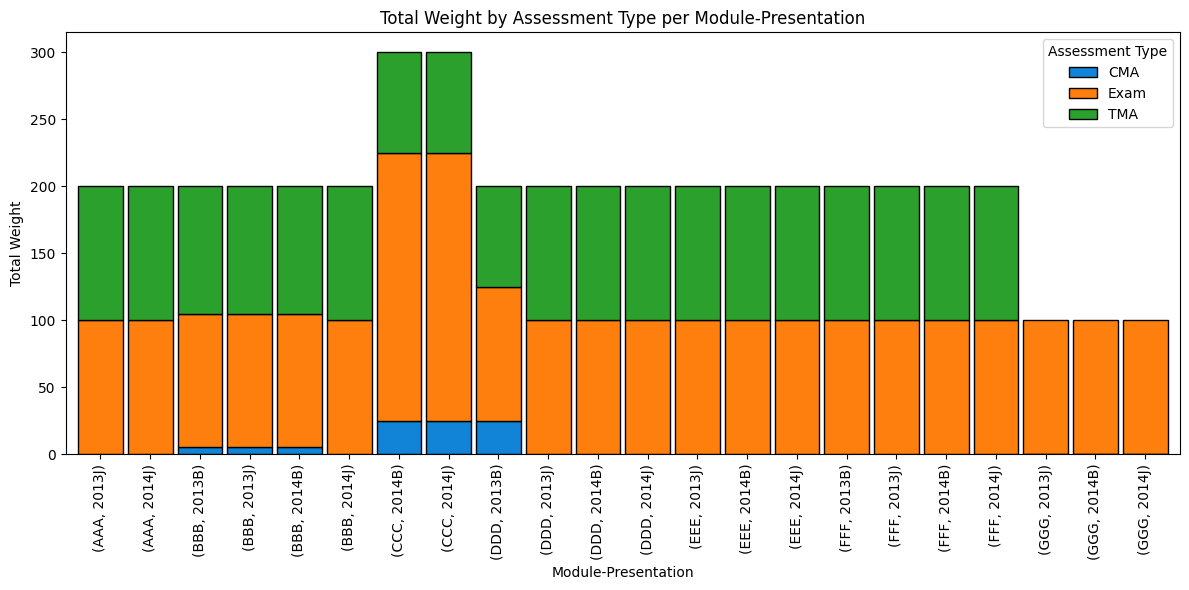

In [1828]:
weights_by_type = course_assess_df.groupby(['code_module', 'code_presentation', 'assessment_type'])['weight'].sum().unstack()


custom_colors = ['#1184d7', '#ff7f0e', '#2ca02c'] 
# Plot total weight by assessment type
weights_by_type.plot(kind='bar', figsize=(12, 6), stacked=True, color=custom_colors, edgecolor='black', width=0.9)

plt.title('Total Weight by Assessment Type per Module-Presentation')
plt.xlabel('Module-Presentation')
plt.ylabel('Total Weight')
plt.xticks(rotation=90)
plt.legend(title='Assessment Type')
plt.tight_layout()
plt.show()

In [1829]:
course_assess_df.isnull().sum()

code_module                   0
code_presentation             0
id_assessment                 0
assessment_type               0
date                          0
weight                        0
module_presentation_length    0
dtype: int64

## Read Student Assessments Data

In [1830]:
stu_assessments_df = datasets['studentAssessment']
stu_assessments_df.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78
1,1752,28400,22,0,70
2,1752,31604,17,0,72
3,1752,32885,26,0,69
4,1752,38053,19,0,79


* id_assessment &rarr; the identification number of the assessment.
<br>
<br>
* id_student &rarr; a unique identification number for the student.
<br>
<br>
* date_submitted &rarr; the date of student submission, measured as the number of days since the start of the module presentation.
<br>
<br>
* is_banked &rarr; a status flag indicating that the assessment result has been transferred from a previous presentation.
<br>
<br>
* score &rarr; the student's score in this assessment. The range is from 0 to 100. The score lower than 40 is interpreted as Fail. The marks are in the range from 0 to 100.

In [1831]:
len(stu_assessments_df[stu_assessments_df['score'] == '?'])

173

In [1832]:
stu_assessments_df.shape

(173912, 5)

In [1833]:
stu_assessments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id_assessment   173912 non-null  int64 
 1   id_student      173912 non-null  int64 
 2   date_submitted  173912 non-null  int64 
 3   is_banked       173912 non-null  int64 
 4   score           173912 non-null  object
dtypes: int64(4), object(1)
memory usage: 6.6+ MB


In [1834]:
stu_assessments_df.score.unique()

array(['78', '70', '72', '69', '79', '71', '68', '73', '67', '83', '66',
       '59', '82', '60', '75', '74', '62', '63', '84', '80', '76', '85',
       '57', '81', '87', '77', '45', '65', '61', '52', '54', '51', '88',
       '58', '64', '55', '38', '91', '47', '89', '36', '86', '49', '53',
       '39', '?', '90', '50', '56', '30', '11', '40', '94', '48', '46',
       '25', '34', '42', '18', '37', '28', '33', '95', '35', '44', '41',
       '15', '0', '43', '93', '32', '92', '98', '24', '19', '27', '29',
       '20', '97', '23', '99', '100', '10', '5', '13', '26', '22', '8',
       '12', '16', '9', '96', '14', '21', '17', '31', '6', '1', '7', '4',
       '2', '3'], dtype=object)

In [1835]:
stu_assessments_df['score'] = pd.to_numeric(stu_assessments_df['score'], errors='coerce')
stu_assessments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [1836]:
#### Remove non-submitted student assessments
non_scoredd_stu_asses_index = stu_assessments_df[ np.isnan(stu_assessments_df).any(axis=1) ].index
stu_assessments_df.drop( index = non_scoredd_stu_asses_index, inplace=True )
print( f'Number of non-submitted student assessments: {len(non_scoredd_stu_asses_index)}' )

Number of non-submitted student assessments: 173


In [1837]:
stu_assessments_df.shape

(173739, 5)

In [1838]:
describe_data( stu_assessments_df )

,count,mean,std,min,25%,50%,75%,max
id_assessment,173739.0,26555.615826,8829.999907,1752.0,15022.0,25359.0,34883.0,37443.0
id_student,173739.0,705247.416717,552482.173324,6516.0,504466.0,585222.0,634500.0,2698588.0
date_submitted,173739.0,116.020226,71.479612,-11.0,51.0,116.0,173.0,608.0
is_banked,173739.0,0.010982,0.104218,0.0,0.0,0.0,0.0,1.0
score,173739.0,75.799573,18.798107,0.0,65.0,80.0,90.0,100.0


In [1839]:
# Finding duplicated rows if any...
stu_assessments_df[ stu_assessments_df.duplicated( subset=['id_assessment', 'id_student'] )]

,id_assessment,id_student,date_submitted,is_banked,score


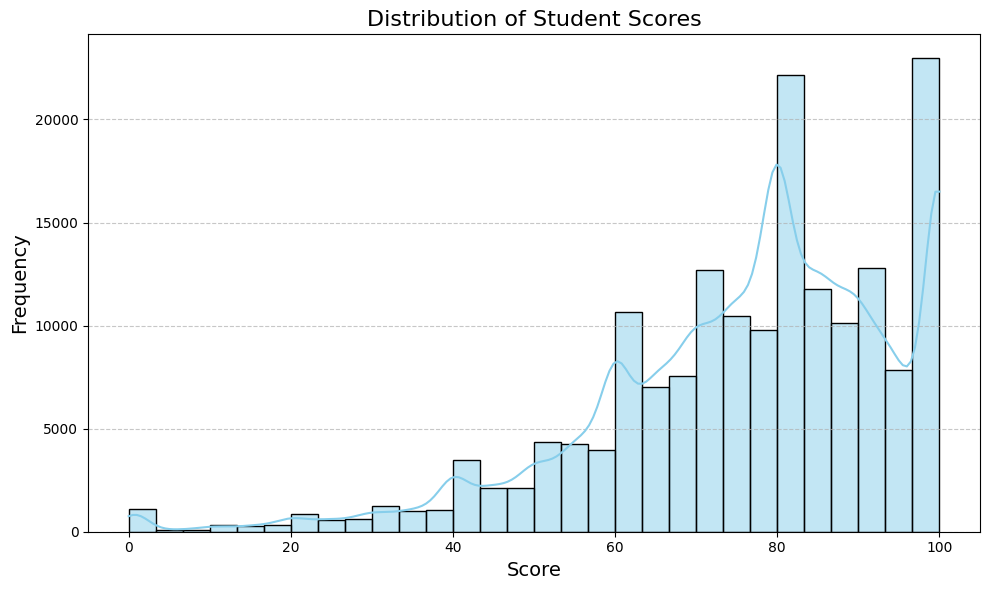

In [1840]:
plt.figure(figsize=(10, 6))
sns.histplot(stu_assessments_df['score'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Student Scores', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [1841]:
stu_assessments_df.shape

(173739, 5)

In [1842]:
course_assess_df.shape

(206, 7)

In [1843]:
common_cols = find_common_columns( course_assess_df, stu_assessments_df )
common_cols

['id_assessment']

### Merging student assessment dataframe with course assessment dataframe

In [1844]:
final_assess_df = pd.merge( course_assess_df, stu_assessments_df, how='inner', on=common_cols )
# final_assess_df.columns = ['code_module', 'code_presentation', 'id_student', 'id_assessment', 'assessment_type', 'date', 'weight', 'is_banked', 'date_submitted', 'score', 'module_presentation_length']
final_assess_df.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length,id_student,date_submitted,is_banked,score
0,AAA,2013J,1752,TMA,19,10.0,268,11391,18,0,78.0
1,AAA,2013J,1752,TMA,19,10.0,268,28400,22,0,70.0
2,AAA,2013J,1752,TMA,19,10.0,268,31604,17,0,72.0
3,AAA,2013J,1752,TMA,19,10.0,268,32885,26,0,69.0
4,AAA,2013J,1752,TMA,19,10.0,268,38053,19,0,79.0


In [1845]:
final_assess_df.shape

(173739, 11)

In [1846]:
final_assess_df = final_assess_df[['code_module', 'code_presentation', 'id_student', 'id_assessment', 'assessment_type', 'date', 'weight', 'is_banked', 'date_submitted', 'score', 'module_presentation_length']]
final_assess_df.head()

,code_module,code_presentation,id_student,id_assessment,assessment_type,date,weight,is_banked,date_submitted,score,module_presentation_length
0,AAA,2013J,11391,1752,TMA,19,10.0,0,18,78.0,268
1,AAA,2013J,28400,1752,TMA,19,10.0,0,22,70.0,268
2,AAA,2013J,31604,1752,TMA,19,10.0,0,17,72.0,268
3,AAA,2013J,32885,1752,TMA,19,10.0,0,26,69.0,268
4,AAA,2013J,38053,1752,TMA,19,10.0,0,19,79.0,268


In [1847]:
""" def calculate_avg_grade(group):
    total_weight = group["weight"].sum()
    if total_weight == 0:
        return 0
    weighted_score = (group["score"] * (group["weight"] / total_weight)).sum()
    return weighted_score
 """

' def calculate_avg_grade(group):\n    total_weight = group["weight"].sum()\n    if total_weight == 0:\n        return 0\n    weighted_score = (group["score"] * (group["weight"] / total_weight)).sum()\n    return weighted_score\n '

In [1848]:
def calculate_avg_grade(group):
    # Calculate total weight
    total_weight = group["weight"].sum()
    if total_weight == 0:
        return 0

    # Split assessments by type
    exam = group[group["assessment_type"] == "Exam"]
    tma = group[group["assessment_type"] == "TMA"]
    cma = group[group["assessment_type"] == "CMA"]

    # Calculate weighted scores for each type
    exam_weighted_score = (exam["score"] * (exam["weight"] / total_weight)).sum()
    tma_weighted_score = (tma["score"] * (tma["weight"] / total_weight)).sum()
    cma_weighted_score = (cma["score"] * (cma["weight"] / total_weight)).sum()

    # Handle special logic for 'CCC' and 'DDD'
    if group["code_module"].iloc[0] in ['CCC', 'DDD']:
        if exam_weighted_score < 40 or (exam_weighted_score >= 40 and tma_weighted_score + cma_weighted_score < exam_weighted_score):
            return exam_weighted_score
        else:
            return tma_weighted_score + cma_weighted_score

    # Default logic for other modules
    weighted_score = (group["score"] * (group["weight"] / total_weight)).sum()
    return weighted_score


In [1849]:
final_assess_df[ final_assess_df.id_student == 11391 ]

,code_module,code_presentation,id_student,id_assessment,assessment_type,date,weight,is_banked,date_submitted,score,module_presentation_length
0,AAA,2013J,11391,1752,TMA,19,10.0,0,18,78.0,268
500,AAA,2013J,11391,1753,TMA,54,20.0,0,53,85.0,268
841,AAA,2013J,11391,1754,TMA,117,20.0,0,115,80.0,268
1030,AAA,2013J,11391,1755,TMA,166,20.0,0,164,85.0,268
1455,AAA,2013J,11391,1756,TMA,215,30.0,0,212,82.0,268


In [1850]:
final_assess_df[final_assess_df['assessment_type'] == 'Exam']['code_module'].unique()

array(['CCC', 'DDD'], dtype=object)

In [1851]:
duplicates = final_assess_df[final_assess_df.duplicated(subset=['id_assessment', 'id_student', 'code_module', 'code_presentation', 'assessment_type'])]
print(f'Number of duplicates: {len(duplicates)}')
duplicates.head()

Number of duplicates: 0


,code_module,code_presentation,id_student,id_assessment,assessment_type,date,weight,is_banked,date_submitted,score,module_presentation_length


In [1852]:
# ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

#### 173 739
group = final_assess_df.groupby(['code_module', 'code_presentation', 'id_student'])

avg_scores = group.apply(calculate_avg_grade).reset_index(name='avg_score')
print('\t\t-----------------\tAverage Score Table\t-----------------\t\t\n')
display(avg_scores)
print('\t\t----------------------------------------------------------\t\t\n')

common_cols = find_common_columns( avg_scores, final_assess_df )

final_assess_df = pd.merge(final_assess_df, avg_scores, on=common_cols, how='inner')
final_assess_df.head()

		-----------------	Average Score Table	-----------------		



,code_module,code_presentation,id_student,avg_score
0,AAA,2013J,11391,82.4
1,AAA,2013J,28400,65.4
2,AAA,2013J,31604,76.3
3,AAA,2013J,32885,55.0
4,AAA,2013J,38053,66.9
...,...,...,...,...
25815,GGG,2014J,2620947,0.0
25816,GGG,2014J,2645731,0.0
25817,GGG,2014J,2648187,0.0
25818,GGG,2014J,2679821,0.0


		----------------------------------------------------------		



,code_module,code_presentation,id_student,id_assessment,assessment_type,date,weight,is_banked,date_submitted,score,module_presentation_length,avg_score
0,AAA,2013J,11391,1752,TMA,19,10.0,0,18,78.0,268,82.4
1,AAA,2013J,28400,1752,TMA,19,10.0,0,22,70.0,268,65.4
2,AAA,2013J,31604,1752,TMA,19,10.0,0,17,72.0,268,76.3
3,AAA,2013J,32885,1752,TMA,19,10.0,0,26,69.0,268,55.0
4,AAA,2013J,38053,1752,TMA,19,10.0,0,19,79.0,268,66.9


In [1853]:
final_assess_df[ (final_assess_df.code_module == 'CCC') & (final_assess_df.assessment_type == 'Exam') & (final_assess_df.avg_score > 40) & (final_assess_df.score < 40)].head(10)

,code_module,code_presentation,id_student,id_assessment,assessment_type,date,weight,is_banked,date_submitted,score,module_presentation_length,avg_score


In [1854]:
final_assess_df.shape

(173739, 12)

In [1855]:
course_assess_summary = final_assess_df.groupby(['code_module', 'code_presentation', 'id_student', 'assessment_type'])\
    .agg(weight_by_type=('weight', 'sum')).reset_index()

course_assess_summary

,code_module,code_presentation,id_student,assessment_type,weight_by_type
0,AAA,2013J,11391,TMA,100.0
1,AAA,2013J,28400,TMA,100.0
2,AAA,2013J,31604,TMA,100.0
3,AAA,2013J,32885,TMA,100.0
4,AAA,2013J,38053,TMA,100.0
...,...,...,...,...,...
44842,GGG,2014J,2648187,TMA,0.0
44843,GGG,2014J,2679821,CMA,0.0
44844,GGG,2014J,2679821,TMA,0.0
44845,GGG,2014J,2684003,CMA,0.0


In [1856]:
# Finding duplicated rows if any...
final_assess_df[ final_assess_df.duplicated( subset=['id_assessment', 'id_student', 'code_module'] )]

,code_module,code_presentation,id_student,id_assessment,assessment_type,date,weight,is_banked,date_submitted,score,module_presentation_length,avg_score


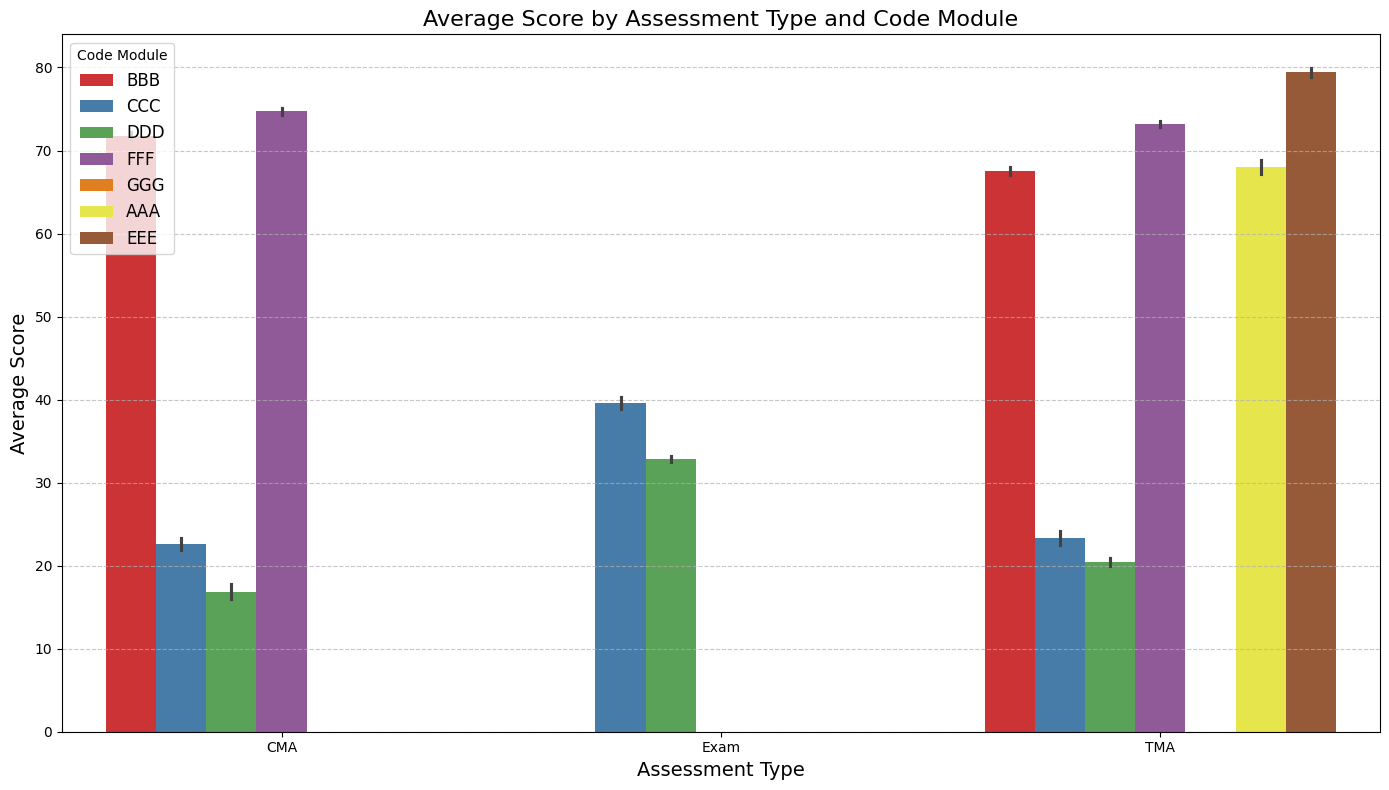

In [1857]:
avg_scores = final_assess_df.groupby(['assessment_type', 'code_module', 'code_presentation', 'id_student'])['avg_score'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.barplot(
    data=avg_scores,
    x='assessment_type',
    y='avg_score',
    hue='code_module',
    palette='Set1'
)
plt.title('Average Score by Assessment Type and Code Module', fontsize=16)
plt.xlabel('Assessment Type', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.legend(title='Code Module', fontsize=12, loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Read Student Info Data

In [1858]:
stu_info_df = datasets['studentInfo']
stu_info_df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [1859]:
describe_data( stu_info_df )

,count,mean,std,min,25%,50%,75%,max
id_student,32593.0,706687.669131,549167.313855,3733.0,508573.0,590310.0,644453.0,2716795.0
num_of_prev_attempts,32593.0,0.163225,0.479758,0.0,0.0,0.0,0.0,6.0
studied_credits,32593.0,79.758691,41.071900,30.0,60.0,60.0,120.0,655.0


In [1860]:
describe_data( data = stu_info_df, isCategorical = True )

,count,unique,top,freq
code_module,32593,7,BBB,7909
code_presentation,32593,4,2014J,11260
gender,32593,2,M,17875
region,32593,13,Scotland,3446
highest_education,32593,5,A Level or Equivalent,14045
imd_band,32593,11,20-30%,3654
age_band,32593,3,0-35,22944
disability,32593,2,N,29429
final_result,32593,4,Pass,12361


In [1861]:
# Checking for null values...
stu_info_df.isnull().sum()

code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
dtype: int64

In [1862]:
# Checking for duplicated colummns...
stu_info_df[ stu_info_df.duplicated(subset=['code_module', 'code_presentation',	'id_student']) ]

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result


In [1863]:
stu_info_df.shape

(32593, 12)

In [1864]:
stu_info_df.final_result.unique()

array(['Pass', 'Withdrawn', 'Fail', 'Distinction'], dtype=object)

In [1865]:
stu_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              32593 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [1866]:
# Remove the student with a final result of 'Withdrawn' since they will not be included in the analysis.
stu_info_df = stu_info_df[ stu_info_df.final_result != 'Withdrawn' ]

In [1867]:
stu_info_df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
5,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass


#### Merging student_info_data with final assessment data

In [1868]:
common_cols = find_common_columns( final_assess_df, stu_info_df )
common_cols

['code_module', 'code_presentation', 'id_student']

In [1869]:
final_student_data = pd.merge( final_assess_df, stu_info_df, how='inner', on=common_cols )
final_student_data.head()

,code_module,code_presentation,id_student,id_assessment,assessment_type,date,weight,is_banked,date_submitted,score,module_presentation_length,avg_score,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,1752,TMA,19,10.0,0,18,78.0,268,82.4,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,1752,TMA,19,10.0,0,22,70.0,268,65.4,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,31604,1752,TMA,19,10.0,0,17,72.0,268,76.3,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
3,AAA,2013J,32885,1752,TMA,19,10.0,0,26,69.0,268,55.0,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
4,AAA,2013J,38053,1752,TMA,19,10.0,0,19,79.0,268,66.9,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass


In [1870]:
final_student_data.shape

(160716, 21)

In [1871]:
# Check if there are any duplicated rows...
final_student_data[ final_student_data.duplicated( subset=['code_module', 'code_presentation', 'id_student', 'id_assessment'] ) ]

,code_module,code_presentation,id_student,id_assessment,assessment_type,date,weight,is_banked,date_submitted,score,module_presentation_length,avg_score,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result


In [1872]:
final_student_data.isnull().sum()

code_module                   0
code_presentation             0
id_student                    0
id_assessment                 0
assessment_type               0
date                          0
weight                        0
is_banked                     0
date_submitted                0
score                         0
module_presentation_length    0
avg_score                     0
gender                        0
region                        0
highest_education             0
imd_band                      0
age_band                      0
num_of_prev_attempts          0
studied_credits               0
disability                    0
final_result                  0
dtype: int64

In [1873]:
final_student_data[ final_student_data.isnull().any(axis=1) ]

,code_module,code_presentation,id_student,id_assessment,assessment_type,date,weight,is_banked,date_submitted,score,module_presentation_length,avg_score,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result


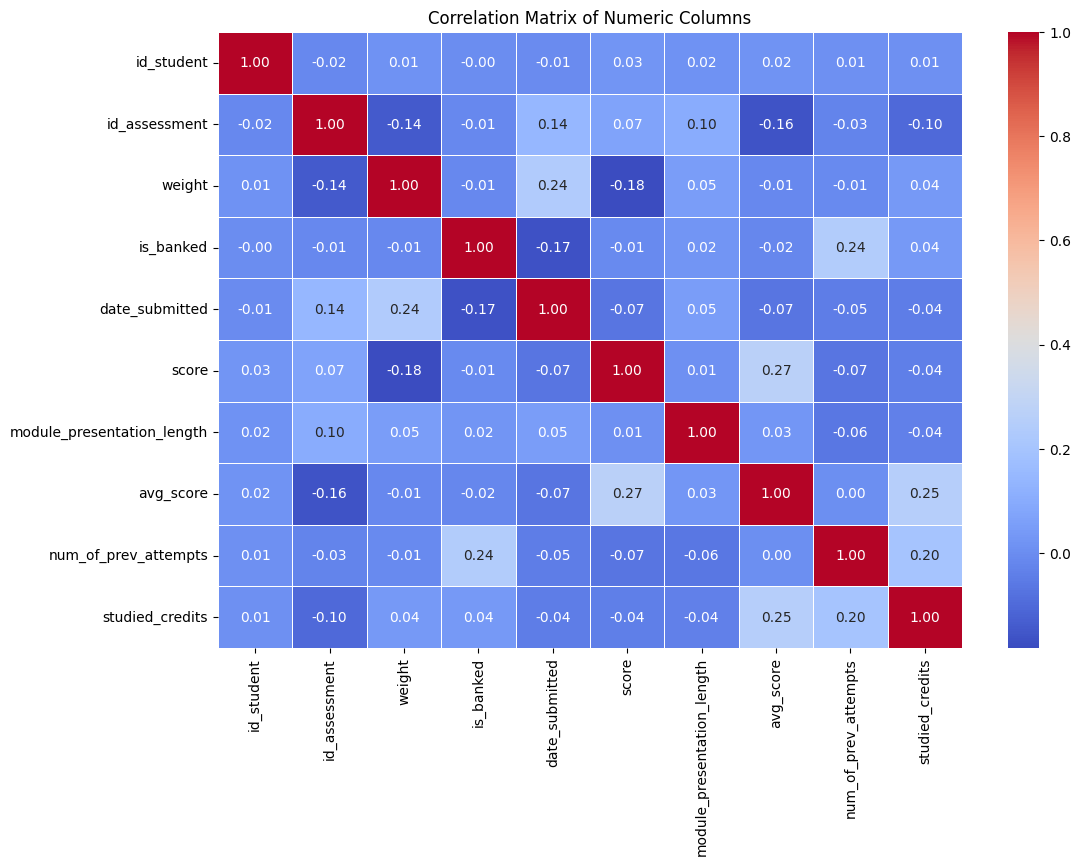

In [1874]:
plt.figure(figsize=(12, 8))
numeric_cols = final_student_data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = final_student_data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

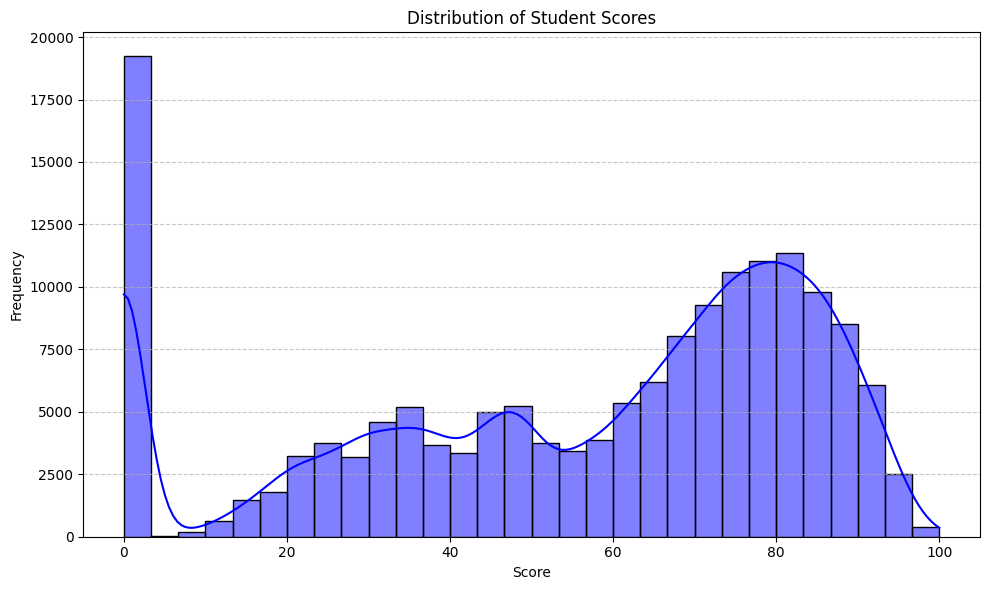

In [1875]:
plt.figure(figsize=(10, 6))
sns.histplot(final_student_data['avg_score'], bins=30, kde=True, color='blue', edgecolor='black')
plt.title('Distribution of Student Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [1876]:
inconsistent_cases = final_student_data[(final_student_data['avg_score'] == 0) & 
                               (final_student_data['final_result'].isin(['Pass', 'Distinction']))]
print(f"Number of inconsistent cases: {len(inconsistent_cases)}")

Number of inconsistent cases: 12893


In [1877]:
# Remove all inconsistent cases from the dataset

final_student_data = final_student_data[~((final_student_data['avg_score'] == 0) & 
                         (final_student_data['final_result'].isin(['Pass', 'Distinction'])))]

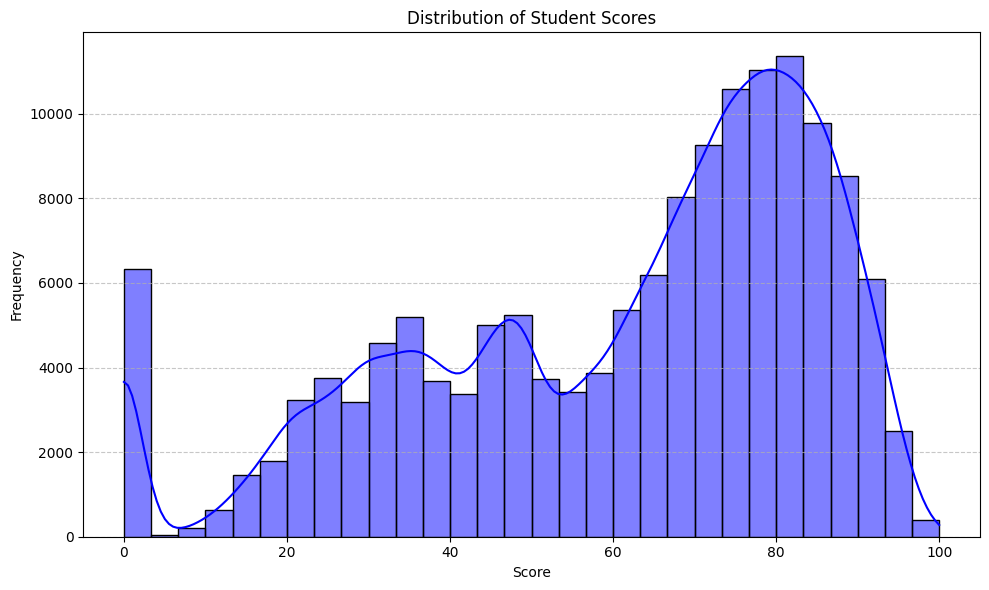

In [1878]:
plt.figure(figsize=(10, 6))
sns.histplot(final_student_data['avg_score'], bins=30, kde=True, color='blue', edgecolor='black')
plt.title('Distribution of Student Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [1879]:
final_student_data.drop( columns=['score'], inplace=True )

In [1880]:
final_student_data.head()

,code_module,code_presentation,id_student,id_assessment,assessment_type,date,weight,is_banked,date_submitted,module_presentation_length,avg_score,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,1752,TMA,19,10.0,0,18,268,82.4,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,1752,TMA,19,10.0,0,22,268,65.4,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,31604,1752,TMA,19,10.0,0,17,268,76.3,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
3,AAA,2013J,32885,1752,TMA,19,10.0,0,26,268,55.0,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
4,AAA,2013J,38053,1752,TMA,19,10.0,0,19,268,66.9,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass


In [1881]:
final_student_data[ final_student_data.id_student == 28400 ]

,code_module,code_presentation,id_student,id_assessment,assessment_type,date,weight,is_banked,date_submitted,module_presentation_length,avg_score,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
1,AAA,2013J,28400,1752,TMA,19,10.0,0,22,268,65.4,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
445,AAA,2013J,28400,1753,TMA,54,20.0,0,52,268,65.4,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
762,AAA,2013J,28400,1754,TMA,117,20.0,0,121,268,65.4,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
941,AAA,2013J,28400,1755,TMA,166,20.0,0,164,268,65.4,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
1361,AAA,2013J,28400,1756,TMA,215,30.0,0,212,268,65.4,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass


In [1882]:
duplicated_rows = final_student_data[ final_student_data.duplicated( subset=['code_module', 'code_presentation', 'id_student', 'gender', 'region', 'imd_band', 'age_band'], keep='first' ) ].index
final_student_data.drop( index = duplicated_rows, inplace=True )
print( f'Number of duplicated rows: {len(duplicated_rows)}' )

Number of duplicated rows: 128192


In [1883]:
final_student_data[ final_student_data.id_student == 28400 ]

,code_module,code_presentation,id_student,id_assessment,assessment_type,date,weight,is_banked,date_submitted,module_presentation_length,avg_score,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
1,AAA,2013J,28400,1752,TMA,19,10.0,0,22,268,65.4,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass


In [1884]:
final_student_data.shape

(19631, 20)

## Read Student Registration Data

In [1885]:
stu_reg_df = datasets[ 'studentRegistration' ]
stu_reg_df.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159,?
1,AAA,2013J,28400,-53,?
2,AAA,2013J,30268,-92,12
3,AAA,2013J,31604,-52,?
4,AAA,2013J,32885,-176,?


In [1886]:
describe_data( data = stu_reg_df )

,count,mean,std,min,25%,50%,75%,max
id_student,32593.0,706687.669131,549167.313855,3733.0,508573.0,590310.0,644453.0,2716795.0


In [1887]:
describe_data( data = stu_reg_df, isCategorical = True )

,count,unique,top,freq
code_module,32593,7,BBB,7909
code_presentation,32593,4,2014J,11260
date_registration,32593,333,-22,1034
date_unregistration,32593,417,?,22521


In [1888]:
stu_reg_df.isnull().sum()

code_module            0
code_presentation      0
id_student             0
date_registration      0
date_unregistration    0
dtype: int64

In [1889]:
stu_reg_df[ stu_reg_df.duplicated( subset=['code_module', 'code_presentation', 'id_student'] ) ]

,code_module,code_presentation,id_student,date_registration,date_unregistration


In [1890]:
number_of_withdrawn = len(stu_reg_df[ stu_reg_df.date_unregistration != '?' ])
print( f'Number of withdrawn students: {number_of_withdrawn}' )

Number of withdrawn students: 10072


In [1891]:
withdrawn_students_index = stu_reg_df[ stu_reg_df.date_unregistration != '?' ].index
stu_reg_df.drop( index=withdrawn_students_index, inplace=True )

#### Merging Student Registration with Final Student Data

In [1892]:
final_student_data = pd.merge( final_student_data, stu_reg_df, how='inner', on=['code_module', 'code_presentation', 'id_student'] )
final_student_data.head()

,code_module,code_presentation,id_student,id_assessment,assessment_type,date,weight,is_banked,date_submitted,module_presentation_length,avg_score,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration
0,AAA,2013J,11391,1752,TMA,19,10.0,0,18,268,82.4,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159,?
1,AAA,2013J,28400,1752,TMA,19,10.0,0,22,268,65.4,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53,?
2,AAA,2013J,31604,1752,TMA,19,10.0,0,17,268,76.3,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52,?
3,AAA,2013J,32885,1752,TMA,19,10.0,0,26,268,55.0,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176,?
4,AAA,2013J,38053,1752,TMA,19,10.0,0,19,268,66.9,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,-110,?


In [1893]:
# Mark the unregistration date of students as 0 since they did not unregistered yet.
final_student_data['date_unregistration'] = final_student_data['date_unregistration'].replace( '?', 0 )
final_student_data.head()

,code_module,code_presentation,id_student,id_assessment,assessment_type,date,weight,is_banked,date_submitted,module_presentation_length,avg_score,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration
0,AAA,2013J,11391,1752,TMA,19,10.0,0,18,268,82.4,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159,0
1,AAA,2013J,28400,1752,TMA,19,10.0,0,22,268,65.4,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53,0
2,AAA,2013J,31604,1752,TMA,19,10.0,0,17,268,76.3,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52,0
3,AAA,2013J,32885,1752,TMA,19,10.0,0,26,268,55.0,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176,0
4,AAA,2013J,38053,1752,TMA,19,10.0,0,19,268,66.9,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,-110,0


In [1894]:
final_student_data.shape

(19629, 22)

## Read Student VLE Data

* code_module &rarr; an identification code for a module.
<br>
<br>
* code_presentation &rarr; the identification code of the module presentation.
<br>
<br>
* id_student &rarr; a unique identification number for the student.
<br>
<br>
* id_site &rarr; an identification number for the VLE material.
<br>
<br>
* date &rarr; the date of student's interaction with the material measured as the number of days since the start of the module&rarr;presentation.
<br>
<br>
* sum_click &rarr; the number of times a student interacts with the material in that day.

In [1895]:
stu_vle_df = datasets[ 'studentVle' ]
stu_vle_df.head()

stu_vle_df[ stu_vle_df['id_student'] == 28400 ].head(10)

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1
5,AAA,2013J,28400,546652,-10,8
6,AAA,2013J,28400,546876,-10,2
7,AAA,2013J,28400,546688,-10,15
8,AAA,2013J,28400,546662,-10,17
9,AAA,2013J,28400,546890,-10,1


In [1896]:
df_temp_vle = stu_vle_df.copy() ### Temporiraly created after Analysis 6 I would delete it.

In [1897]:
stu_vle_df.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [1898]:
stu_vle_df = stu_vle_df.groupby(['code_module', 'code_presentation', 'id_student'])['sum_click'].sum().reset_index()

In [1899]:
stu_vle_df.head()

,code_module,code_presentation,id_student,sum_click
0,AAA,2013J,11391,934
1,AAA,2013J,28400,1435
2,AAA,2013J,30268,281
3,AAA,2013J,31604,2158
4,AAA,2013J,32885,1034


In [1900]:
# Find common columns between the two DataFrames
common_cols = list(set(stu_vle_df.columns.tolist()) & set(final_student_data.columns.tolist()))
common_cols

['code_module', 'code_presentation', 'id_student']

In [1901]:
stu_vle_df.shape, final_student_data.shape

((29228, 4), (19629, 22))

#### Merging Final Student Data with Student VLE

In [1902]:
final_student_data = pd.merge( final_student_data, stu_vle_df, how='inner', on=common_cols)
final_student_data.head()

,code_module,code_presentation,id_student,id_assessment,assessment_type,date,weight,is_banked,date_submitted,module_presentation_length,avg_score,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,sum_click
0,AAA,2013J,11391,1752,TMA,19,10.0,0,18,268,82.4,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159,0,934
1,AAA,2013J,28400,1752,TMA,19,10.0,0,22,268,65.4,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53,0,1435
2,AAA,2013J,31604,1752,TMA,19,10.0,0,17,268,76.3,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52,0,2158
3,AAA,2013J,32885,1752,TMA,19,10.0,0,26,268,55.0,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176,0,1034
4,AAA,2013J,38053,1752,TMA,19,10.0,0,19,268,66.9,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,-110,0,2445


In [1903]:
### Drop the unnecessary columns
final_student_data.drop( columns=['weight', 'is_banked', 'module_presentation_length', 'gender', 'region'], inplace=True )

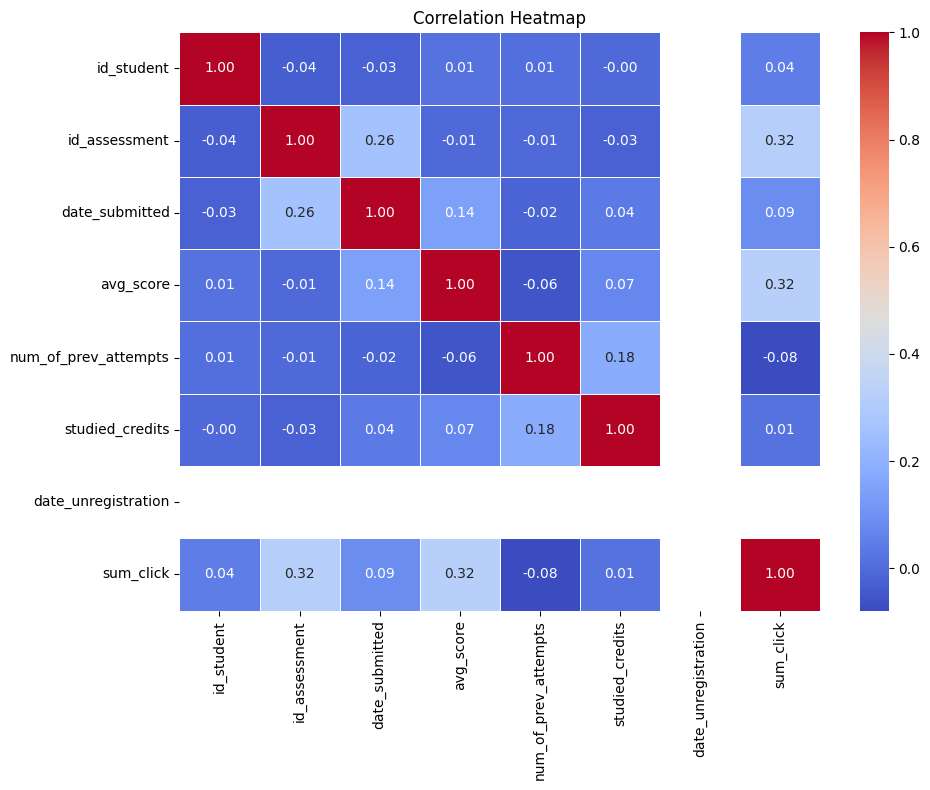

In [1904]:
numeric_cols = final_student_data.select_dtypes(include=['float64', 'int64']).columns
corr = final_student_data[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [1905]:
### Drop more columns as our analysis show that they are not beneficial
final_student_data.drop( columns=['date', 'date_submitted', 'date_registration', 'date_unregistration', 'studied_credits'], inplace=True )

In [1906]:
## Search for any NULL values
final_student_data.isnull().sum()

code_module             0
code_presentation       0
id_student              0
id_assessment           0
assessment_type         0
avg_score               0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
disability              0
final_result            0
sum_click               0
dtype: int64

In [1907]:
final_student_data.shape

(19599, 13)

In [1908]:
## Search for duplicated rows
final_student_data[ final_student_data.duplicated(subset=['code_module', 'code_presentation', 'id_student', 'id_assessment', 'assessment_type', 'highest_education', 'imd_band', 'age_band']) ]

,code_module,code_presentation,id_student,id_assessment,assessment_type,avg_score,highest_education,imd_band,age_band,num_of_prev_attempts,disability,final_result,sum_click


## Read VLE Data

In [1909]:
vle_df = datasets[ 'vle' ]
vle_df.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,?,?
1,546712,AAA,2013J,oucontent,?,?
2,546998,AAA,2013J,resource,?,?
3,546888,AAA,2013J,url,?,?
4,547035,AAA,2013J,resource,?,?


In [1910]:
describe_data( vle_df )

,count,mean,std,min,25%,50%,75%,max
id_site,6364.0,726099.094123,128315.137473,526721.0,661592.75,730096.5,814016.25,1077905.0


In [1911]:
describe_data( vle_df, isCategorical = True )

,count,unique,top,freq
code_module,6364,7,FFF,1967
code_presentation,6364,4,2013J,1772
activity_type,6364,20,resource,2660
week_from,6364,31,?,5243
week_to,6364,31,?,5243


In [1912]:
## Search for any NULL values
vle_df.isnull().sum()

id_site              0
code_module          0
code_presentation    0
activity_type        0
week_from            0
week_to              0
dtype: int64

In [1913]:
## Search for duplicated rows
vle_df[ vle_df.duplicated(subset=['id_site', 'code_module', 'code_presentation', 'activity_type']) ]

,id_site,code_module,code_presentation,activity_type,week_from,week_to


In [1914]:
common_cols = list( set( vle_df.columns.tolist() ) & set( final_student_data.columns.tolist() ) )
common_cols

['code_module', 'code_presentation']

## MY ANALYSIS WOULD NOT REQUIRED ANYTHING ABOUT VLE DATASET. SO I AM NOT MERGING IT WITH MY FINAL DATASET

In [1915]:
final_data = final_student_data.copy()

In [1916]:
final_data[final_data.duplicated()]

,code_module,code_presentation,id_student,id_assessment,assessment_type,avg_score,highest_education,imd_band,age_band,num_of_prev_attempts,disability,final_result,sum_click


In [1917]:
final_data.final_result

0        Pass
1        Pass
2        Pass
3        Pass
4        Pass
         ... 
19594    Fail
19595    Fail
19596    Fail
19597    Fail
19598    Fail
Name: final_result, Length: 19599, dtype: object

In [1918]:
# Outlier Detection
def detect_outliers_iqr(df, column):
    """Detect outliers using the IQR method."""
    Q3 = df[column].quantile(0.9)
    upper_bound = Q3 
    outliers = df[df[column] > upper_bound]
    return outliers

# Removing Outliers
def remove_outliers(df, column):
    """Remove outliers using the IQR method."""
    Q3 = df[column].quantile(0.9)
    upper_bound = Q3
    return df[df[column] <= upper_bound]

In [1919]:
# Identify outliers for numeric columns
numeric_columns = final_data[['num_of_prev_attempts', 'sum_click']]
outliers_summary = {col: len(detect_outliers_iqr(final_data, col)) for col in numeric_columns}
print("\nOutliers Summary:\n", outliers_summary)



Outliers Summary:
 {'num_of_prev_attempts': 500, 'sum_click': 1960}


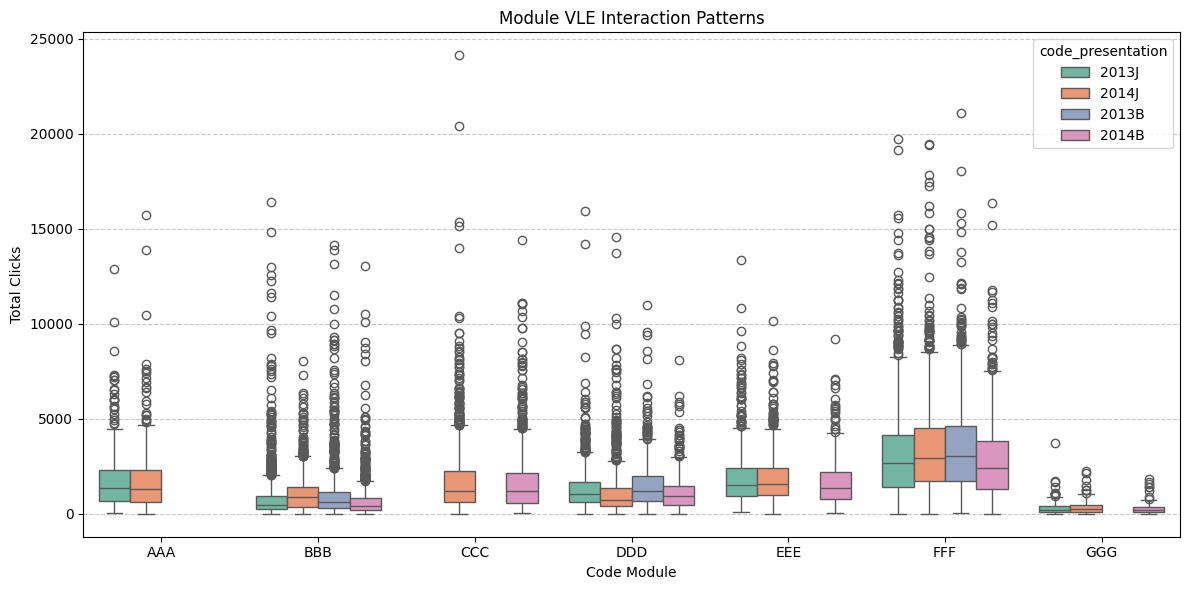

In [1920]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=final_data, x='code_module', y='sum_click', hue='code_presentation', palette='Set2')
plt.title('Module VLE Interaction Patterns')
plt.xlabel('Code Module')
plt.ylabel('Total Clicks')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [1921]:
final_data = remove_outliers(final_data, 'num_of_prev_attempts')
final_data = remove_outliers(final_data, 'sum_click')
final_data.shape

(17191, 13)

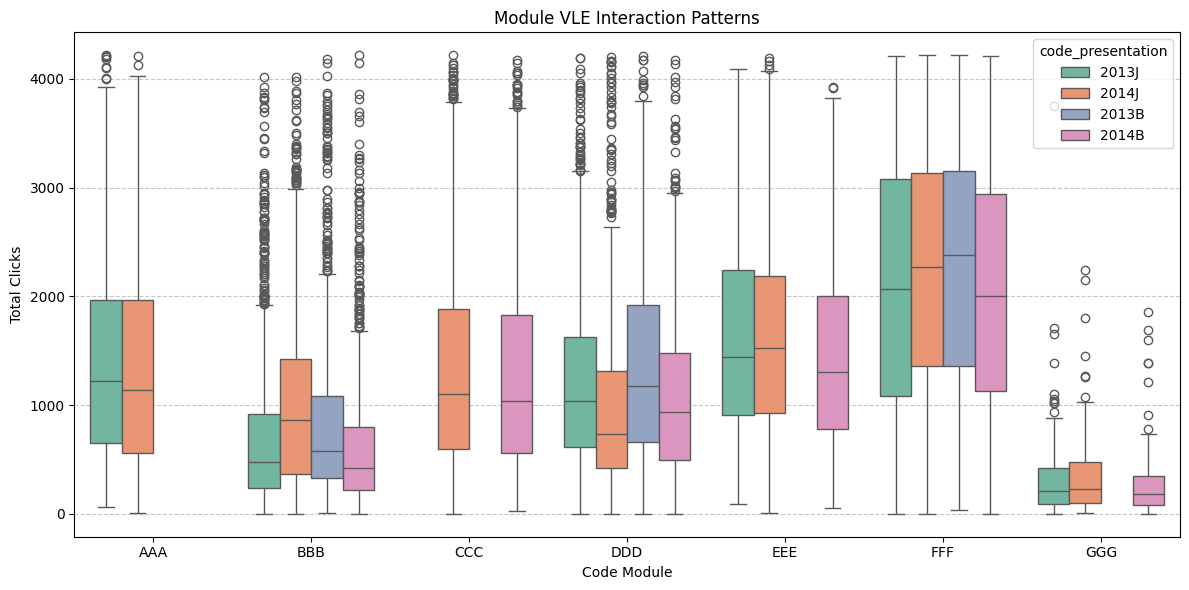

In [1922]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=final_data, x='code_module', y='sum_click', hue='code_presentation', palette='Set2')
plt.title('Module VLE Interaction Patterns')
plt.xlabel('Code Module')
plt.ylabel('Total Clicks')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [1923]:
final_data["final_result"] = final_data.apply(
    lambda row: "Pass" if row["avg_score"] > 40 else "Fail",
    axis=1
)

In [1924]:
final_data[ (final_data.avg_score > 40) & (final_data.final_result == 'Fail') ]

,code_module,code_presentation,id_student,id_assessment,assessment_type,avg_score,highest_education,imd_band,age_band,num_of_prev_attempts,disability,final_result,sum_click


In [1925]:
final_data.head()

,code_module,code_presentation,id_student,id_assessment,assessment_type,avg_score,highest_education,imd_band,age_band,num_of_prev_attempts,disability,final_result,sum_click
0,AAA,2013J,11391,1752,TMA,82.4,HE Qualification,90-100%,55<=,0,N,Pass,934
1,AAA,2013J,28400,1752,TMA,65.4,HE Qualification,20-30%,35-55,0,N,Pass,1435
2,AAA,2013J,31604,1752,TMA,76.3,A Level or Equivalent,50-60%,35-55,0,N,Pass,2158
3,AAA,2013J,32885,1752,TMA,55.0,Lower Than A Level,50-60%,0-35,0,N,Pass,1034
4,AAA,2013J,38053,1752,TMA,66.9,A Level or Equivalent,80-90%,35-55,0,N,Pass,2445


In [1926]:
# final_data = final_data[ final_data.code_module != 'GGG' ]

### Analysis 1: Top 5 modules chosen by students

In [1927]:
cleaned_final_data = final_data.copy()

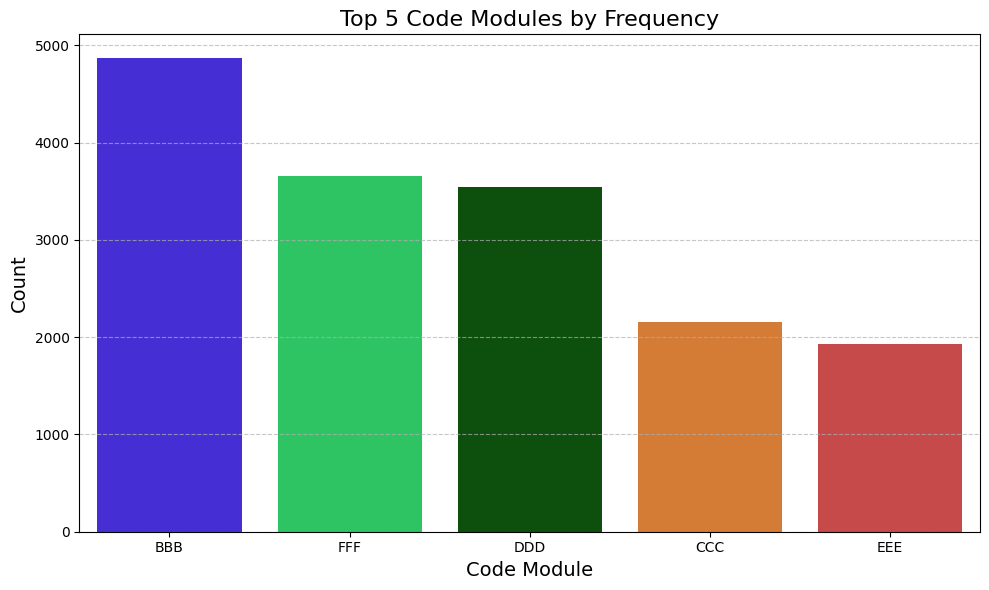

,code_module,count
0,BBB,4869
1,FFF,3652
2,DDD,3548
3,CCC,2151
4,EEE,1931


In [1928]:
top_5_modules = cleaned_final_data['code_module'].value_counts().nlargest(5).reset_index()
top_5_modules.columns = ['code_module', 'count']

custom_colors = ['#3113f0', '#16dd5c', '#025a02', '#ee771c', '#dc3535']

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=top_5_modules, x='code_module', y='count', palette=custom_colors)
plt.title('Top 5 Code Modules by Frequency', fontsize=16)
plt.xlabel('Code Module', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(),
plt.show()

display( top_5_modules )

### Analysis 2: The top 5 modules with the highest average score

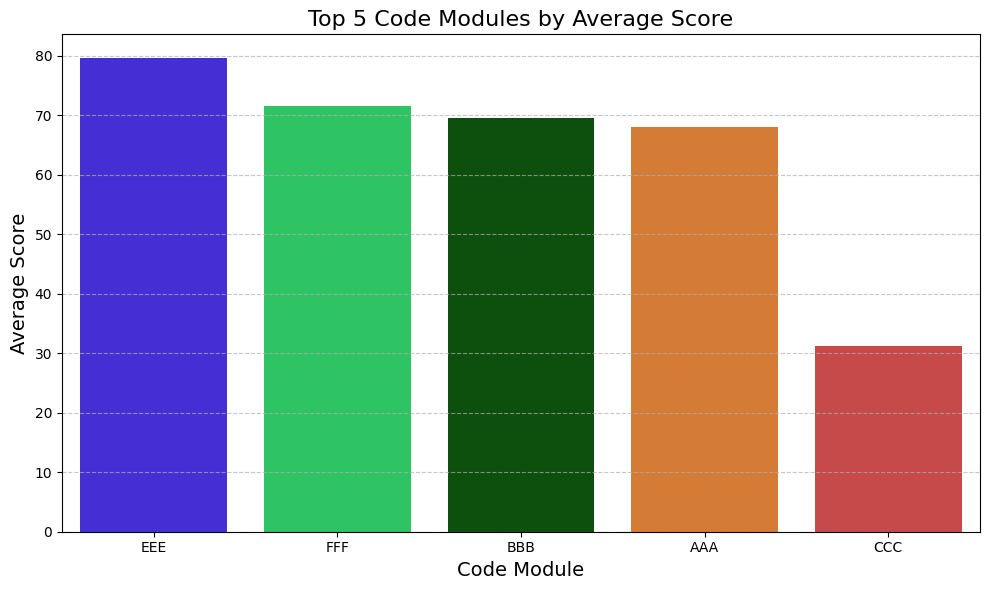

,code_module,avg_score
0,EEE,79.599605
1,FFF,71.535195
2,BBB,69.500751
3,AAA,67.935053
4,CCC,31.192695


In [1929]:
top_5_modules_high_avg = cleaned_final_data.groupby('code_module')['avg_score'].mean().sort_values(ascending=False).nlargest(5).reset_index()
top_5_modules_high_avg.columns = ['code_module', 'avg_score']

custom_colors = ['#3113f0', '#16dd5c', '#025a02', '#ee771c', '#dc3535']

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=top_5_modules_high_avg, x='code_module', y='avg_score', palette=custom_colors)
plt.title('Top 5 Code Modules by Average Score', fontsize=16)
plt.xlabel('Code Module', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(),
plt.show()

display( top_5_modules_high_avg )

### Analysis 3: The top 5 modules with the lowest average score

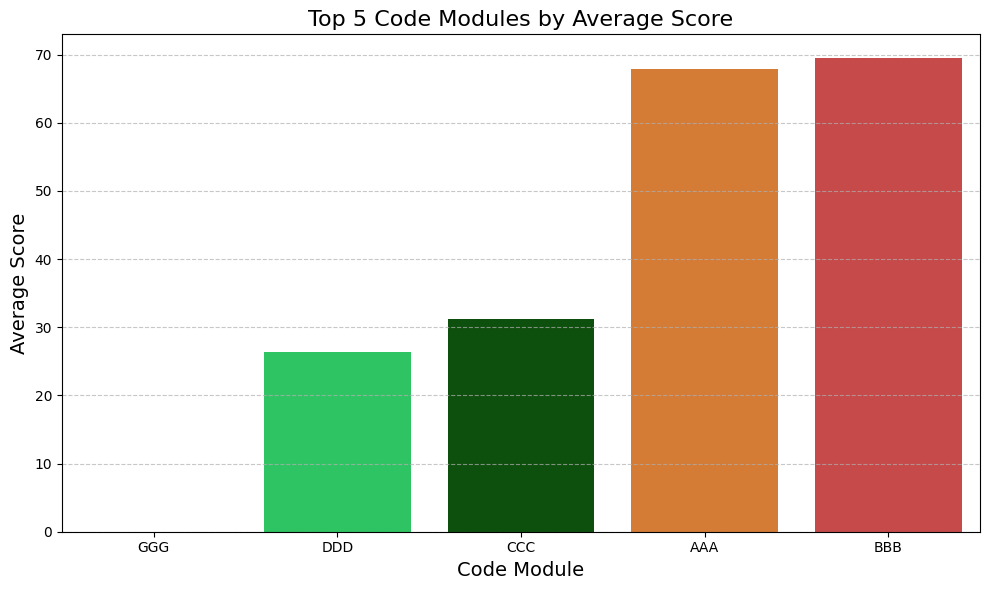

,code_module,avg_score
0,GGG,0.000000
1,DDD,26.434445
2,CCC,31.192695
3,AAA,67.935053
4,BBB,69.500751


In [1930]:
top_5_modules_low_avg = cleaned_final_data.groupby('code_module')['avg_score'].mean().sort_values(ascending=False).nsmallest(5).reset_index()
top_5_modules_low_avg.columns = ['code_module', 'avg_score']

custom_colors = ['#3113f0', '#16dd5c', '#025a02', '#ee771c', '#dc3535']

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=top_5_modules_low_avg, x='code_module', y='avg_score', palette=custom_colors)
plt.title('Top 5 Code Modules by Average Score', fontsize=16)
plt.xlabel('Code Module', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(),
plt.show()

display( top_5_modules_low_avg)

### Analysis 4: The top 5 modules with the most number of fails

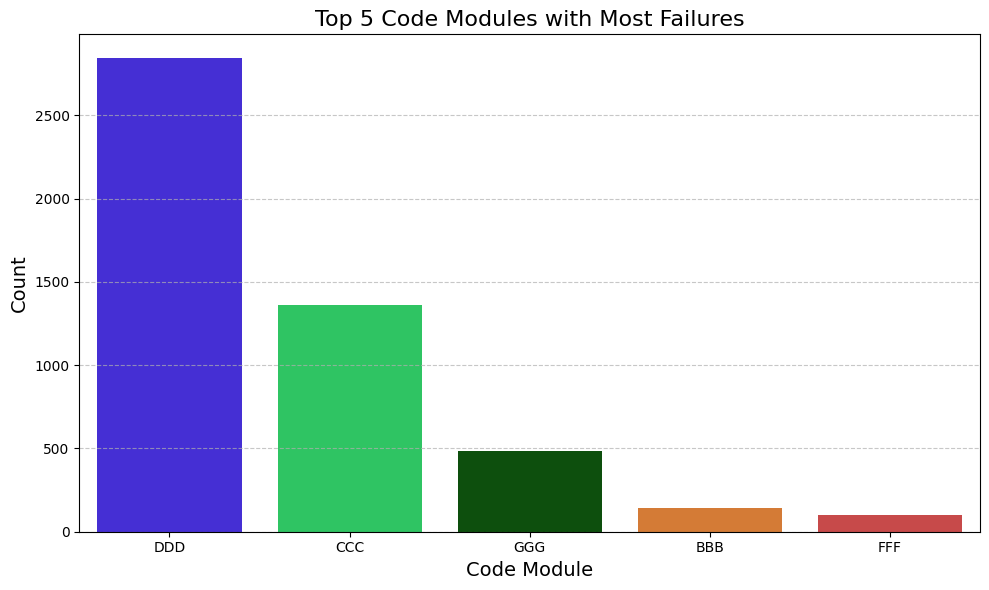

,code_module,count
0,DDD,2845
1,CCC,1361
2,GGG,484
3,BBB,140
4,FFF,102


In [1931]:
failures = cleaned_final_data[cleaned_final_data['final_result'] == 'Fail']['code_module'].value_counts().sort_values(ascending=False).nlargest(5).reset_index()
failures.columns = ['code_module', 'count']

custom_colors = ['#3113f0', '#16dd5c', '#025a02', '#ee771c', '#dc3535']

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=failures, x='code_module', y='count', palette=custom_colors)
plt.title('Top 5 Code Modules with Most Failures', fontsize=16)
plt.xlabel('Code Module', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(),
plt.show()

display( failures )

### Analysis 5: The age distribution of the students

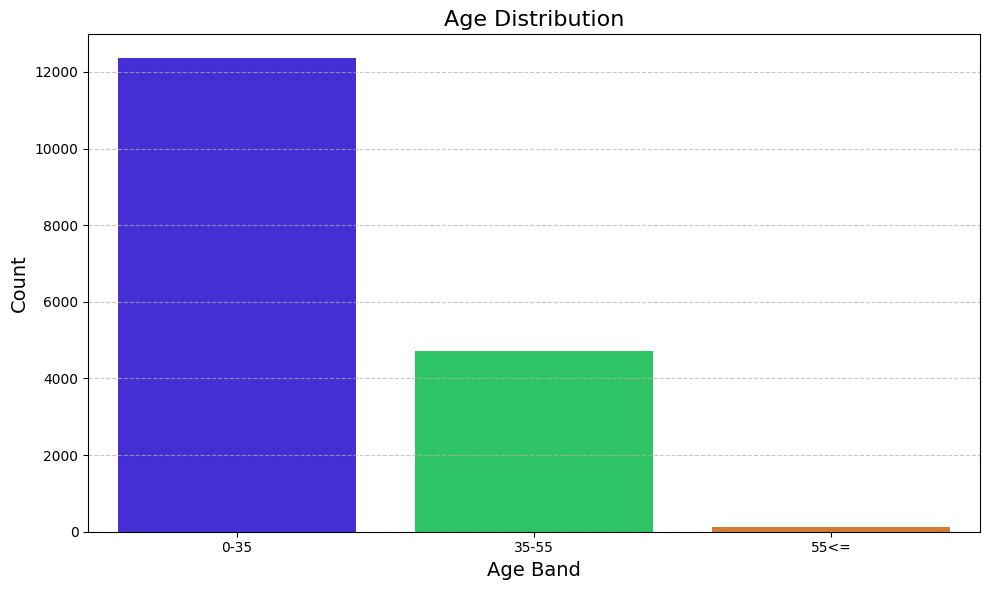

,age_band,count
0,0-35,12364
1,35-55,4704
2,55<=,123


In [1932]:
age_distribution = cleaned_final_data.age_band.value_counts().reset_index()
age_distribution.columns = ['age_band', 'count']

custom_colors = ['#3113f0', '#16dd5c', '#ee771c']

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=age_distribution, x='age_band', y='count', palette=custom_colors)
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age Band', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(),
plt.show()

display( age_distribution )

### Analysis 6: The weekly activity patterns of the students' interaction with the VLE

,code_module,code_presentation,id_student,id_site,date,sum_click,week
0,AAA,2013J,28400,546652,-10,4,2
1,AAA,2013J,28400,546652,-10,1,2
2,AAA,2013J,28400,546652,-10,1,2
3,AAA,2013J,28400,546614,-10,11,2
4,AAA,2013J,28400,546714,-10,1,2


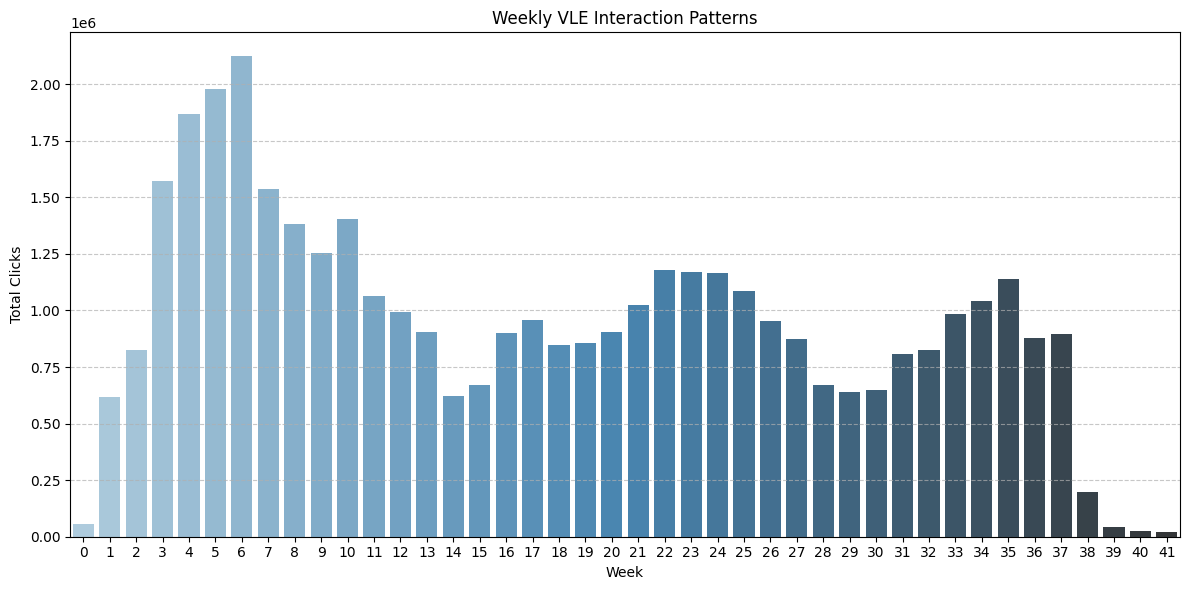

In [1933]:
min_date = df_temp_vle['date'].min()
max_date = df_temp_vle['date'].max()


bins = np.arange(min_date, max_date + 7, 7) 
labels = range(len(bins)-1 )  
df_temp_vle['week'] = pd.cut(df_temp_vle['date'], bins=bins, labels=labels, right=False)
display( df_temp_vle.head() )

weekly_activity = df_temp_vle.groupby([ 'week'], as_index=False)['sum_click'].sum()

# Plot weekly activity using barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=weekly_activity, x='week', y='sum_click', palette='Blues_d')
plt.title('Weekly VLE Interaction Patterns')
plt.xlabel('Week')
plt.ylabel('Total Clicks')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

del df_temp_vle

### Hypothesis Testing
We aim to apply ANOVA test if the vle interactions of a student has an effect on their final results.

### Hypotheses

- **Null Hypothesis (H₀):** The interaction level with the VLE (`sum_click`) has no impact on the likelihood of passing the course. The mean `sum_click` is the same across all `final_result` categories.
- **Alternative Hypothesis (H₁):** Students with higher interaction levels with the VLE (`sum_click`) have a higher likelihood of passing the course. The mean `sum_click` differs across `final_result` categories.

### Reason for ANOVA Test:
ANOVA was applied because:
- The dependent variable, `sum_click`, is continuous.
- The independent variable, `final_result`, is categorical with two groups: "Pass" & "Fail"
- ANOVA evaluates whether the means of `sum_click` differ significantly across these groups.

### Test Results:
- **F-statistic**: 20652.18
- **p-value**: 0.0

### Conclusion:
There is a statistically significant difference in VLE interaction levels (`sum_click`) among the `final_result` categories, indicating that higher interaction with the VLE is associated with better chances of passing the course.



In [1934]:
median_sum_click = cleaned_final_data['sum_click'].median()
cleaned_final_data['interaction_level'] = cleaned_final_data['sum_click'].apply(
    lambda x: 'High' if x > median_sum_click else 'Low'
)
cleaned_final_data.head()

,code_module,code_presentation,id_student,id_assessment,assessment_type,avg_score,highest_education,imd_band,age_band,num_of_prev_attempts,disability,final_result,sum_click,interaction_level
0,AAA,2013J,11391,1752,TMA,82.4,HE Qualification,90-100%,55<=,0,N,Pass,934,Low
1,AAA,2013J,28400,1752,TMA,65.4,HE Qualification,20-30%,35-55,0,N,Pass,1435,High
2,AAA,2013J,31604,1752,TMA,76.3,A Level or Equivalent,50-60%,35-55,0,N,Pass,2158,High
3,AAA,2013J,32885,1752,TMA,55.0,Lower Than A Level,50-60%,0-35,0,N,Pass,1034,Low
4,AAA,2013J,38053,1752,TMA,66.9,A Level or Equivalent,80-90%,35-55,0,N,Pass,2445,High


In [1935]:
# Filter the data for students who either "Pass" or "Fail"
filtered_data = cleaned_final_data[cleaned_final_data['final_result'].isin(['Pass', 'Fail'])]

# Prepare groups for ANOVA
high_interaction = filtered_data[filtered_data['interaction_level'] == 'High']
low_interaction = filtered_data[filtered_data['interaction_level'] == 'Low']

In [1936]:
fail_rates = {
    'high': len(high_interaction[high_interaction['final_result'] == 'Fail']) / len(high_interaction) * 100,
    'low': len(low_interaction[low_interaction['final_result'] == 'Fail']) / len(low_interaction) * 100
}

success_rates = {
    'high': len(high_interaction[(high_interaction['final_result'] == 'Pass')]) / len(high_interaction) * 100,
    'low': len(low_interaction[(low_interaction['final_result'] == 'Pass')]) / len(low_interaction) * 100
}


In [1937]:
print( f'Fail Rates:\nHigh Interactions => {fail_rates.get("high"):.2f}%\nLow Interaction => {fail_rates.get("low"):.2f}%')

Fail Rates:
High Interactions => 20.91%
Low Interaction => 36.74%


In [1938]:
print( f'Success Rates:\nHigh Interactions => {success_rates.get("high"):.2f}%\nLow Interaction => {success_rates.get("low"):.2f}%')

Success Rates:
High Interactions => 79.09%
Low Interaction => 63.26%


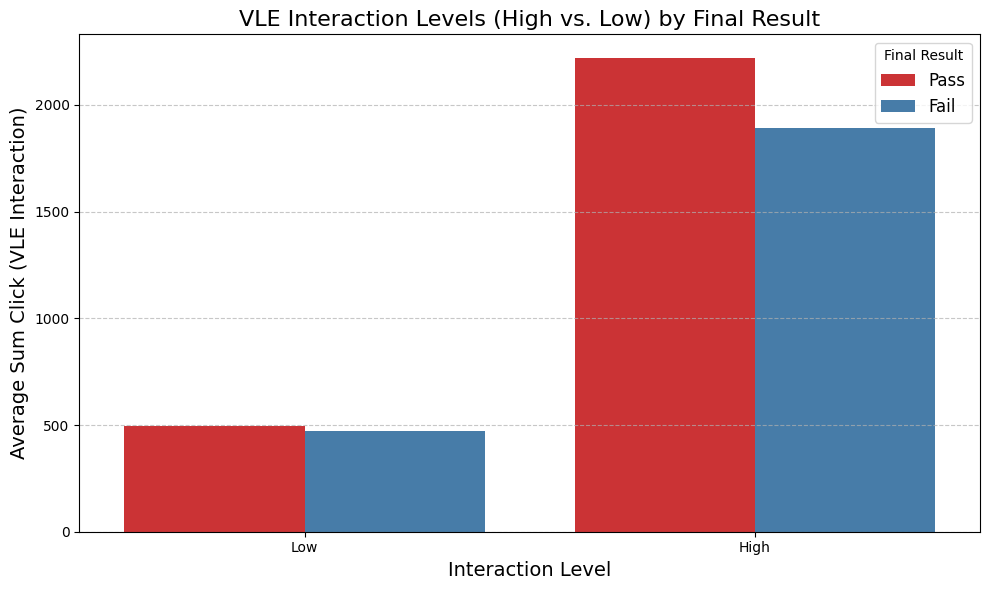

{'F-statistic': np.float64(29424.06565252733), 'p-value': np.float64(0.0)}

In [1939]:
# Perform ANOVA
anova_result = f_oneway(
    high_interaction['sum_click'],
    low_interaction['sum_click']
)

# Visualize the relationship using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=filtered_data, x='interaction_level', y='sum_click',
    hue='final_result', ci=None, palette='Set1'
)
plt.title('VLE Interaction Levels (High vs. Low) by Final Result', fontsize=16)
plt.xlabel('Interaction Level', fontsize=14)
plt.ylabel('Average Sum Click (VLE Interaction)', fontsize=14)
plt.legend(title='Final Result', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print ANOVA results
anova_summary = {
    "F-statistic": anova_result.statistic,
    "p-value": anova_result.pvalue
}

anova_summary


In [1940]:
low_success_rate = round( success_rates.get("low"), 2 )
high_success_rate = round( success_rates.get("high"), 2 )

success_rate_improvement = ( high_success_rate - low_success_rate ) / low_success_rate * 100

print( f'Success Rates are increased by {success_rate_improvement:.2f}%' )

Success Rates are increased by 25.02%


In [1941]:
low_fail_rate = round( fail_rates.get("low"), 2 )
high_fail_rate = round( fail_rates.get("high"), 2 )

fail_rate_improvement = ( high_fail_rate - low_fail_rate ) / low_fail_rate * 100

print( f'Fail Rates are decreased by {fail_rate_improvement:.2f}%' )

Fail Rates are decreased by -43.09%


### Machine Learning Application

#### Transform some categorical columns to numerical by mapping.

In [1942]:
mapping_education = {
    edu: idx + 1 for idx, edu in enumerate(cleaned_final_data['highest_education'].unique().tolist())
}

mapping_final_result = {
    'Pass': 1,
    'Fail': 0
}

display( mapping_education )
display( mapping_final_result )

{'HE Qualification': 1,
 'A Level or Equivalent': 2,
 'Lower Than A Level': 3,
 'Post Graduate Qualification': 4,
 'No Formal quals': 5}

{'Pass': 1, 'Fail': 0}

In [1943]:
cleaned_final_data['highest_education'] = cleaned_final_data['highest_education'].map(mapping_education)
cleaned_final_data['final_result'] = cleaned_final_data['final_result'].map(mapping_final_result)

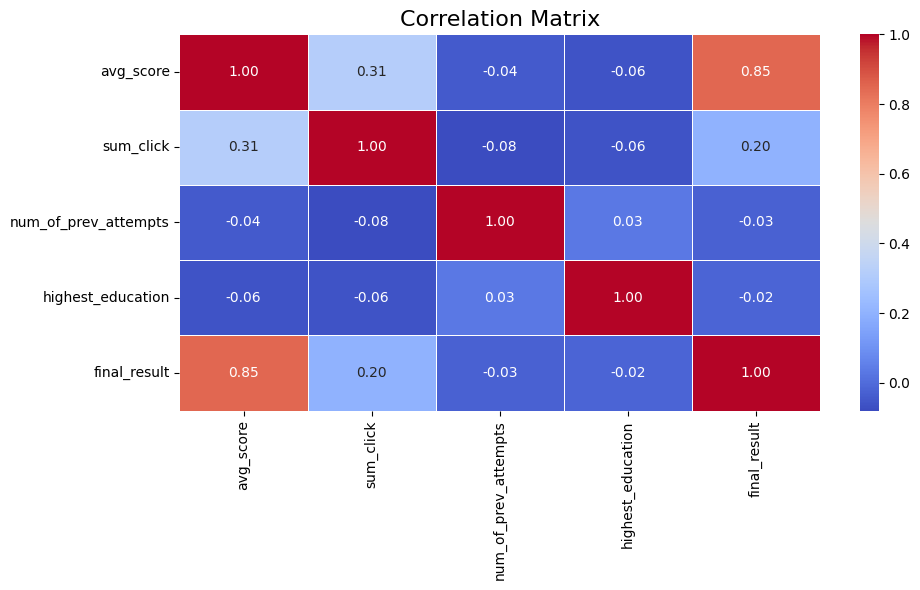

In [1944]:
# Correlation matrix to check multicollinearity
correlation_matrix = cleaned_final_data[['avg_score', 'sum_click', 'num_of_prev_attempts', 'highest_education', 'final_result']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

#### A Scatter ploting to check if our data is appropiate for Linear Regression

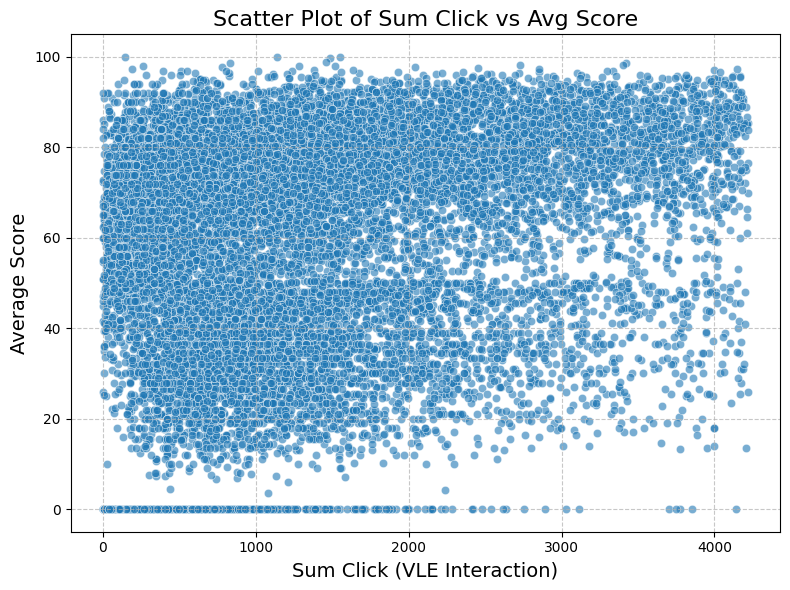

In [1945]:
# Scatter plot to check linearity
plt.figure(figsize=(8, 6))
sns.scatterplot(data=cleaned_final_data, x='sum_click', y='avg_score', alpha=0.6)
plt.title('Scatter Plot of Sum Click vs Avg Score', fontsize=16)
plt.xlabel('Sum Click (VLE Interaction)', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### &rarr; The data we obtained is not suitable for Linear Regression Modelling, hence I am going to further my model with Decision Tree Classifier

In [1946]:
cleaned_final_data.select_dtypes(include=['object']).columns

Index(['code_module', 'code_presentation', 'assessment_type', 'imd_band', 'age_band', 'disability', 'interaction_level'], dtype='object')

#### DT Classifier Model

In [1947]:
cleaned_final_data.head()

,code_module,code_presentation,id_student,id_assessment,assessment_type,avg_score,highest_education,imd_band,age_band,num_of_prev_attempts,disability,final_result,sum_click,interaction_level
0,AAA,2013J,11391,1752,TMA,82.4,1,90-100%,55<=,0,N,1,934,Low
1,AAA,2013J,28400,1752,TMA,65.4,1,20-30%,35-55,0,N,1,1435,High
2,AAA,2013J,31604,1752,TMA,76.3,2,50-60%,35-55,0,N,1,2158,High
3,AAA,2013J,32885,1752,TMA,55.0,3,50-60%,0-35,0,N,1,1034,Low
4,AAA,2013J,38053,1752,TMA,66.9,2,80-90%,35-55,0,N,1,2445,High


In [1948]:
cleaned_final_data.shape

(17191, 14)

In [1949]:
features = ['code_module', 'highest_education', 'num_of_prev_attempts', 'sum_click']
cat_feature = [ f for f in features if f in cleaned_final_data.select_dtypes(include=['object']).columns ]

X = cleaned_final_data[features]
y = cleaned_final_data["final_result"]

X = pd.get_dummies(X, columns=cat_feature).astype('float64')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(13752, 3439, 13752, 3439)

In [1950]:
len(X.columns)

10

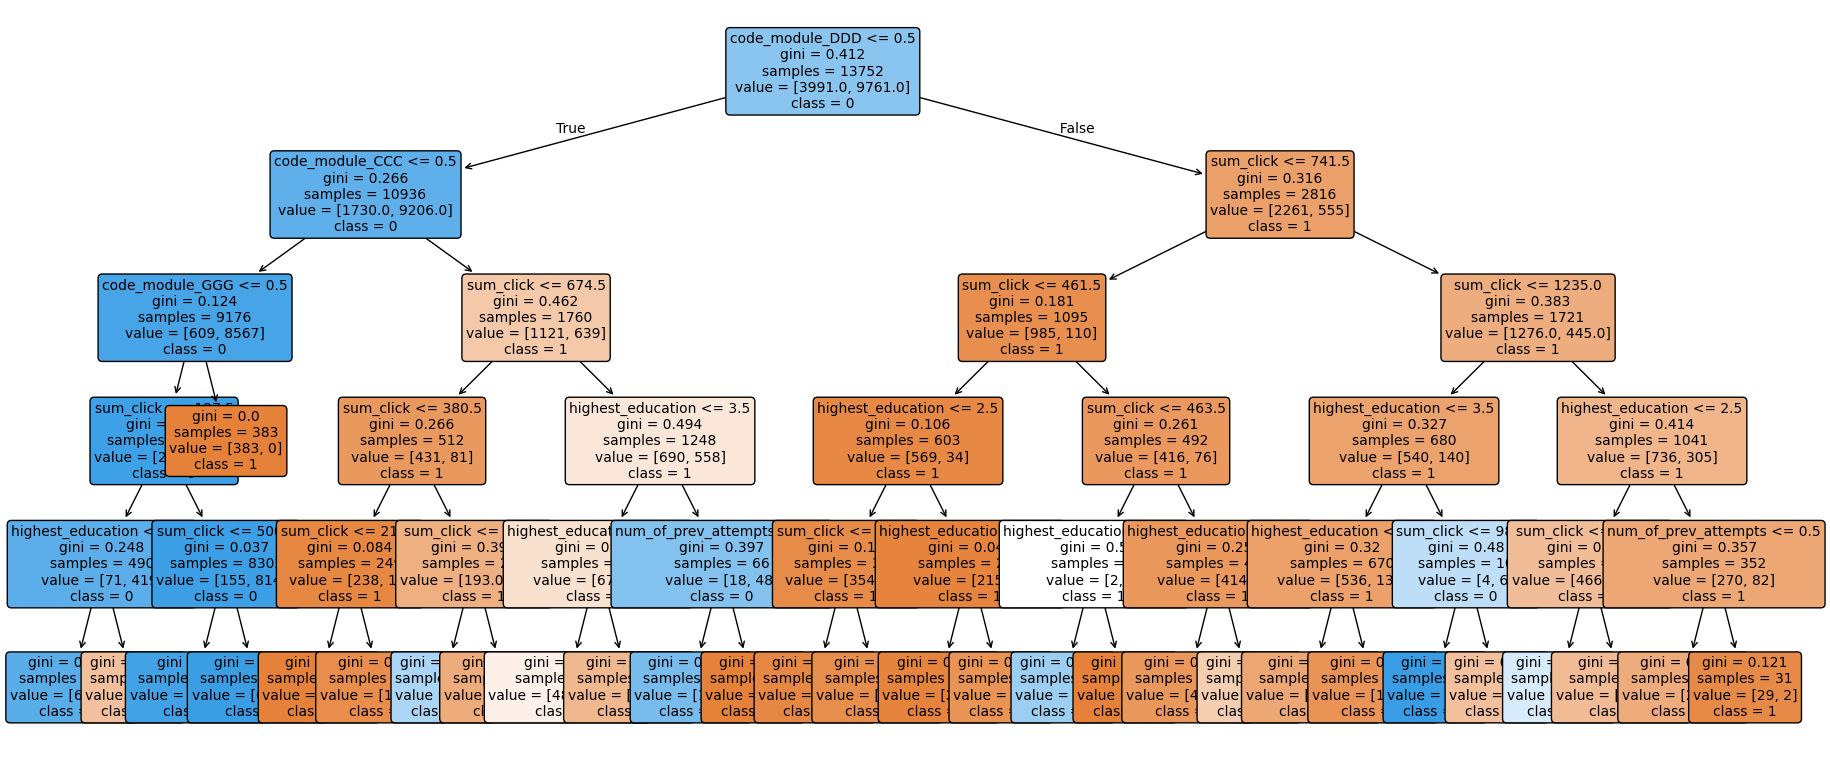

In [1951]:
model = DecisionTreeClassifier(max_depth=5, random_state=42)

res = model.fit(X_train, y_train)

# Plot the Decision Tree
fig, ax = plt.subplots(nrows=1, ncols=1)
_ = plot_tree(
    res, 
    feature_names=X.columns, 
    class_names=[str(label) for label in y.unique()],  # Convert class names to strings
    ax=ax, 
    fontsize=10, 
    filled=True, 
    rounded=True
)

# Adjust figure size
fig.set_figheight(fig.get_figheight() * 2)
fig.set_figwidth(fig.get_figwidth() * 3.5)
plt.show()

In [1952]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy * 100:.2f}")
print(f"Precision: {precision * 100:.2f}")
print(f"Recall: {recall * 100:.2f}")
print(f"F1 Score: {f1 * 100:.2f}")

Accuracy: 90.20
Precision: 86.94
Recall: 91.67
F1 Score: 88.66


In [1953]:
# train accuracy score 
y_pred_train = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy * 100:.2f}")

Train Accuracy: 90.00


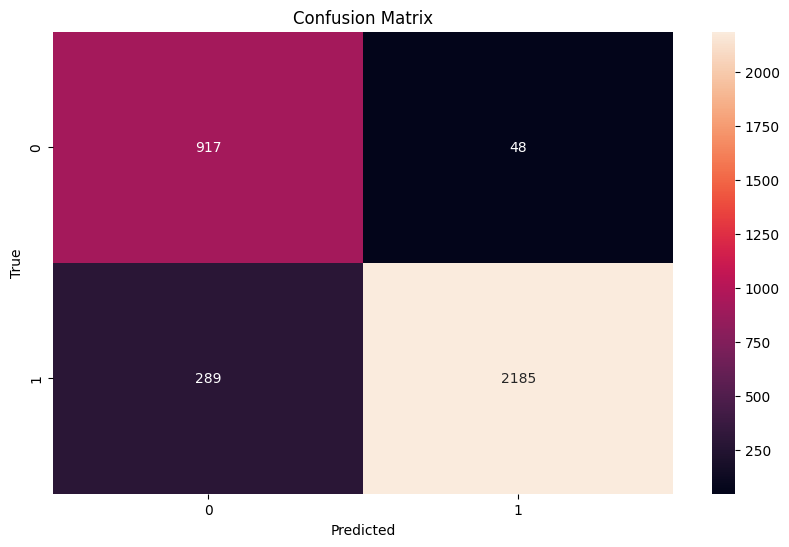

In [1954]:
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Feature Selection

In [1955]:
# Recursive Feature Elimination (RFE)
num_features = list(range(1, len(X.columns) + 1))
rfe_features = {nf: {} for nf in num_features}

for nf in num_features:
    rfe = RFE(model, n_features_to_select=nf)
    rfe.fit(X_train, y_train)
    selected_features = X_train.columns[rfe.support_]
    new_X_train = X_train[selected_features]
    new_X_test = X_test[selected_features]
    
    # Train and evaluate the model with selected features
    model.fit(new_X_train, y_train)
    y_pred = model.predict(new_X_test)
    rfe_features[nf] = {
        "score": accuracy_score(y_test, y_pred),
        "features": list(selected_features)
    }

print("RFE Feature Selection Results:")

data = [
    {"num_features": int(k), "score": f'{v["score"]:.5f}', "features": ", ".join(v["features"])}
    for k, v in rfe_features.items()
]
df = pd.DataFrame(data)

pd.set_option('display.max_colwidth', None)
display(df)

RFE Feature Selection Results:


,num_features,score,features
0,1,0.84618,code_module_DDD
1,2,0.87206,"code_module_CCC, code_module_DDD"
2,3,0.90142,"code_module_CCC, code_module_DDD, code_module_GGG"
3,4,0.90753,"sum_click, code_module_CCC, code_module_DDD, code_module_GGG"
4,5,0.90172,"highest_education, sum_click, code_module_CCC, code_module_DDD, code_module_GGG"
5,6,0.90201,"highest_education, num_of_prev_attempts, sum_click, code_module_CCC, code_module_DDD, code_module_GGG"
6,7,0.90201,"highest_education, num_of_prev_attempts, sum_click, code_module_CCC, code_module_DDD, code_module_FFF, code_module_GGG"
7,8,0.90201,"highest_education, num_of_prev_attempts, sum_click, code_module_CCC, code_module_DDD, code_module_EEE, code_module_FFF, code_module_GGG"
8,9,0.90201,"highest_education, num_of_prev_attempts, sum_click, code_module_BBB, code_module_CCC, code_module_DDD, code_module_EEE, code_module_FFF, code_module_GGG"
9,10,0.90201,"highest_education, num_of_prev_attempts, sum_click, code_module_AAA, code_module_BBB, code_module_CCC, code_module_DDD, code_module_EEE, code_module_FFF, code_module_GGG"


In [1956]:
largest_features_value = max( df['score'].sort_values(ascending=False).to_list() )
# best_features_rfe = df.iloc[largest_features_index]
best_features_rfe = df[df['score'] == largest_features_value]
best_features_rfe

,num_features,score,features
3,4,0.90753,"sum_click, code_module_CCC, code_module_DDD, code_module_GGG"
